# Water Security

### Downloading all data

In [2]:
# Make sure you've run aws configure before hand
!aws s3 sync s3://s3groupegypt data

In [36]:
import datetime as dateformat
import pandas as pd
import numpy as np
from shapely.geometry import Point, box
import matplotlib.pyplot as plt
import geopandas
import geoplot
import h5py
import warnings
from tqdm import tqdm
import pickle
import re
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
%matplotlib inline
import seaborn as sns; sns.set()
from sklearn.decomposition import PCA
from sklearn import preprocessing
from bioinfokit.analys import get_data
from bioinfokit.visuz import cluster


warnings.filterwarnings('ignore')

## Preprocessing

This section allows you to run the full pipeline from the raw data files. The full pipeline takes around 11 minutes. Alternatively, just go to the checkpoint section below and load the final master data frame.

In [4]:
# Merge 0.5x0.5 degree cells into 1x1 degree cells.
# We overlay 1x1 degree cells on the world and intersect with co-ordinates
# and aggregate using average.
# This is pretty generic and infact works with any x degree cell.
def geodataframe_overlay_grid_cells(degrees=1):
    grid = []
    for lat in np.arange(-180, 180, degrees):
        for lon in np.arange(-360, 360, degrees):
            grid.append(box(lat, lon, lat+degrees, lon+degrees))
    return grid

def geodataframe_merge_adjacent_cells(df, degrees=1, aggfunc='mean'):
    columns = df.columns[:-1]
    grid = pd.DataFrame(data={'id': np.arange(0, 360*720)})
    crs = {'init': 'epsg:4326'}
    gf = geopandas.GeoDataFrame(grid, crs=crs, geometry=geodataframe_overlay_grid_cells(degrees=degrees))
    gf_intersect = geopandas.sjoin(gf, df, how="inner", op='intersects')
    b = gf_intersect.dissolve(by='id', aggfunc = 'mean')
    return geopandas.GeoDataFrame(b[columns], geometry=b.geometry.centroid)

# Converts dataframe to geodataframe
# Dataframe must contain lon/lat fields!
def dataframe_to_geodataframe(df):
    crs = {'init': 'epsg:4326'}
    geo = [Point(row['lon'], row['lat']) for (_, row) in df[['lon', 'lat']].iterrows()]
    gdf = geopandas.GeoDataFrame(df, crs=crs, geometry=geo)
    return gdf

frames = []

### Loading SSP2 dataset

Here we load the dataset and visualise the information with a head()/google map

In [5]:
# This dataset has population estimates every decade. We linearly impute 
# the intermediate years.
def ssp2_linear_impute(df, prefix, from_year, to_year):
    df[["%c2_%s" % (prefix, i) for i in np.arange(from_year, to_year) if i % 10]] = np.nan
    df_t = df[["%c2_%s" % (prefix, i) for i in np.arange(from_year, to_year)]].transpose()
    df_it = df_t.interpolate(method='linear', direction = 'forward').transpose()
    df_it[["lon", "lat"]] = df[["px", "py"]]
    return df_it

# Read, Impute, GeoDataFrame, Center on grid
def ssp2_load_population(from_year=1980, to_year=2017):
    population = pd.read_csv("data/SSP2/pop_ssp2.csv")
    population = ssp2_linear_impute(population, prefix="p", from_year=from_year, to_year=to_year)
    population = dataframe_to_geodataframe(population)
    population = geodataframe_merge_adjacent_cells(population)
    return population

def ssp2_load_gdp(from_year=1980, to_year=2017):
    gdp = pd.read_csv("data/SSP2/gdp_ssp2.csv")
    gdp = ssp2_linear_impute(gdp, prefix="g", from_year=from_year, to_year=to_year)
    gdp = dataframe_to_geodataframe(gdp)
    gdp = geodataframe_merge_adjacent_cells(gdp)
    return gdp

In [6]:
population = ssp2_load_population()
gdp = ssp2_load_gdp()

frames.append(population)
frames.append(gdp)

### Loading Water GAP dataset

Here we load the dataset and visualise the information with a head()/google map

In [7]:
#Condition- function starts from year 1980, 
# nc4_file_path -> str ,nc4_key -> str, datatype either monthly or yearly
def watergap_nc4_to_dataframe(nc4_key, nc4_file, yearN=1980):
    nc4f = h5py.File(nc4_file, 'r')
    key = nc4f[nc4_key][:]
    lat = nc4f['lat'][:]
    lon = nc4f['lon'][:]
    year = yearN
    is_monthly = 'monthly' in nc4_file

    # monthly data
    if is_monthly:
        start = (yearN - 1900 - 1)*12;
        
        #Jan of YearN to Dec of 2016
        for i in range(start, nc4f[nc4_key].shape[0]):
            data = key[i,:,:]
            if i == start:
                month = 1
                data_pd = pd.DataFrame(data = data)
                lat = nc4f['lat'][:]
                data_pd.index =  lat
                lon = nc4f['lon'][:]
                data_pd.columns = lon
                data_pd = pd.melt(data_pd, ignore_index = False, var_name='lon', value_name=str(dateformat.datetime(year, 1, month).strftime('%m/%d/%Y')))               
            else:
                data_I = pd.DataFrame(data = data)
                data_I.index =  lat
                
                if i % 12 == 0:
                    year = year+1
                    month = 1
                else:
                    month = month + 1
                    
                data_I = pd.melt(data_I,ignore_index = False, value_name= str(dateformat.datetime(year, month,1).strftime('%m/%d/%Y')))
                data_pd[str(dateformat.datetime(year,month,1).strftime('%m/%d/%Y'))] = data_I.loc[:,str(dateformat.datetime(year,month,1).strftime('%m/%d/%Y'))]
        
        # Convert to Yearly Data
        data_ion = data_pd['lon']
        data_no_ion = data_pd.drop(columns=['lon'])
        new = (data_no_ion.groupby(pd.PeriodIndex(data_no_ion.columns, freq='Y'), axis=1).mean().rename(columns=lambda c: str(c).lower()))
        data_pd=pd.concat([data_ion, new], axis=1) 
        
    # yearly data
    else:
        start = year - 1900 - 1;

        #YearN to 2016
        for i in range(start, nc4f[nc4_key].shape[0]):
            data = key[i,:,:]
            if i == start:
                data_pd = pd.DataFrame(data = data)
                lat = nc4f['lat'][:]
                data_pd.index =  lat
                lon = nc4f['lon'][:]
                data_pd.columns = lon
                data_pd = pd.melt(data_pd, ignore_index = False, var_name='lon', value_name=str(yearN))
            else:
                data_I = pd.DataFrame(data = data)
                data_I.index =  lat
                year = year+1
                data_I = pd.melt(data_I,ignore_index = False, value_name= str(year))
                data_pd[str(year)] = data_I.loc[:,str(year)]

    data_pd['lat'] = data_pd.index
    data_pd = data_pd.add_suffix('_%s' % nc4_key)
    data_pd.rename(columns={'lat_%s' % nc4_key : 'lat', 'lon_%s' % nc4_key : 'lon' }, inplace=True)
    return data_pd.reset_index(drop=True)

def watergap_load(key, period):
    filename = 'data/WaterGap/watergap_22d_WFDEI-GPCC_histsoc_%s_%s_1901_2016.nc4' % (key, period)
    d = watergap_nc4_to_dataframe(nc4_key=key, nc4_file=filename)
    return d


def watergap_load_all():
    watergap_vars = [("anag", "monthly"),
                 ("anas", "monthly"),
                 ("atotuse", "monthly"),
                 ("canopystor", "monthly"),
                 ("dis", "monthly"),
                 ("evap", "monthly"),
                 ("glolakestor", "monthly"),
                 ("glowetlandstor", "monthly"),
                 ("groundwstor", "monthly"),
                 ("loclakestor", "monthly"),
                 ("locwetlandstor", "monthly"),
                 ("ncrun", "monthly"),
                 ("pdomuse", "yearly"),
                 ("pdomww", "yearly"),
                 ("pgwuse", "monthly"),
                 ("pgwww", "monthly"),
                 ("pinduse", "yearly"),
                 ("pindww", "yearly"),
                 ("pirruse", "monthly"),
                 ("pirrww", "monthly"),
                 ("plivuse", "yearly"),
                 ("pnag", "monthly"),
                 ("pnas", "monthly"),
                 ("potevap", "monthly"),
                 ("precmon", "monthly"),
                 ("ptotuse", "monthly"),
                 ("ptotww", "monthly"),
                 ("qg", "monthly"),
                 ("ql", "monthly"),
                 ("qr", "monthly"),
                 ("qrdif", "monthly"),
                 ("qrswb", "monthly"),
                 ("qs", "monthly"),
                 ("reservoirstor", "monthly"),
                 ("riverstor", "monthly"),
                 ("soilmoist", "monthly"),
                 ("swe", "monthly"),
                 ("tws", "monthly"),
                 ("disnat", "monthly"),
                 ("ncrunnat", "monthly")]

    local_frames = []
    for (watergap_key, watergap_period) in tqdm(watergap_vars):
        local_frames.append(watergap_load(key=watergap_key, period=watergap_period))
        
    d = local_frames[0]
    for frame in local_frames[1:]:
        d = d.merge(frame)
    
    d = dataframe_to_geodataframe(d)
    d = geodataframe_merge_adjacent_cells(d)
    return d

In [8]:
watergap = watergap_load_all()
watergap.head()

100%|██████████| 40/40 [07:08<00:00, 10.71s/it]


,lon,1980_anag,1981_anag,1982_anag,1983_anag,1984_anag,1985_anag,1986_anag,1987_anag,1988_anag,...,2008_ncrunnat,2009_ncrunnat,2010_ncrunnat,2011_ncrunnat,2012_ncrunnat,2013_ncrunnat,2014_ncrunnat,2015_ncrunnat,2016_ncrunnat,geometry
id,,,,,,,,,,,,,,,,,,,,,
270,-179.5,1.000000e+20,1.000000e+20,1.000000e+20,1.000000e+20,1.000000e+20,1.000000e+20,1.000000e+20,1.000000e+20,1.000000e+20,...,1.000000e+20,1.000000e+20,1.000000e+20,1.000000e+20,1.000000e+20,1.000000e+20,1.000000e+20,1.000000e+20,1.000000e+20,POINT (-179.50000 -89.50000)
271,-179.5,1.000000e+20,1.000000e+20,1.000000e+20,1.000000e+20,1.000000e+20,1.000000e+20,1.000000e+20,1.000000e+20,1.000000e+20,...,1.000000e+20,1.000000e+20,1.000000e+20,1.000000e+20,1.000000e+20,1.000000e+20,1.000000e+20,1.000000e+20,1.000000e+20,POINT (-179.50000 -88.50000)
272,-179.5,1.000000e+20,1.000000e+20,1.000000e+20,1.000000e+20,1.000000e+20,1.000000e+20,1.000000e+20,1.000000e+20,1.000000e+20,...,1.000000e+20,1.000000e+20,1.000000e+20,1.000000e+20,1.000000e+20,1.000000e+20,1.000000e+20,1.000000e+20,1.000000e+20,POINT (-179.50000 -87.50000)
273,-179.5,1.000000e+20,1.000000e+20,1.000000e+20,1.000000e+20,1.000000e+20,1.000000e+20,1.000000e+20,1.000000e+20,1.000000e+20,...,1.000000e+20,1.000000e+20,1.000000e+20,1.000000e+20,1.000000e+20,1.000000e+20,1.000000e+20,1.000000e+20,1.000000e+20,POINT (-179.50000 -86.50000)
274,-179.5,1.000000e+20,1.000000e+20,1.000000e+20,1.000000e+20,1.000000e+20,1.000000e+20,1.000000e+20,1.000000e+20,1.000000e+20,...,1.000000e+20,1.000000e+20,1.000000e+20,1.000000e+20,1.000000e+20,1.000000e+20,1.000000e+20,1.000000e+20,1.000000e+20,POINT (-179.50000 -85.50000)


In [9]:
frames.append(watergap)

### Loading GLDAS dataset

Here we load the dataset and visualise the information with a head()/google map

In [10]:
def gldas_hdf_to_dataframe(year, month):
    year = str(year)
    hdf_file_path = 'data/gldas/GLDAS_CLSM10_M.A%s%02d.021.hdf' % (year, month)
    A = h5py.File(hdf_file_path, 'r')
    list_1 = list(A.keys())
    list_df = pd.DataFrame()
    list_df2 = pd.DataFrame()
    list_df["keys"] = list_1
    lat = A['lat']   
    lon = A['lon'] 
    data_pd = pd.DataFrame()   
    list_df2["keys"] = list_df["keys"].loc[0:37]
    count = 0
    for keys in list_df2["keys"]:
          if keys == 'ACond_tavg':
              data_arr = A[keys][0,:,:]
              data_pd = pd.DataFrame(data = data_arr)
              data_pd.columns = lon
              data_pd.index = lat
              col_n = year + "_" + keys
              data_pd = pd.melt(data_pd, ignore_index = False, var_name='lon', value_name= col_n)
          else:
              data_arr = A[keys][0,:,:]
              data = pd.DataFrame(data = data_arr)
              data.index = lat
              col_n = year + "_" + keys
              data = pd.melt(data, ignore_index = False, value_name= col_n)
              data_pd[col_n] = data.loc[:,col_n]

    data_pd['lat'] = data_pd.index
    return data_pd.reset_index(drop=True)

def gldas_load_all():
    local_frames = []
    for year in tqdm(range(2000, 2017)):
        # We need to merge one year at a time otherwise mem swapouts hit the roof
        d = [gldas_hdf_to_dataframe(year, month) for month in range(1, 13)]
        d = pd.concat(d).groupby(['lon','lat'], group_keys=False, as_index=False).mean()
        local_frames.append(d)
        
    d = local_frames[0]
    for frame in local_frames[1:]:
        d = d.merge(frame)
    d = dataframe_to_geodataframe(d)
    return d

In [11]:
gldas_df = gldas_load_all()

# Use that as main dataframe since GLDAS captures only a subset of the latitudes
# from 60 to -60, which are the interesting latitudes anyways. 
frames.insert(0, gldas_df)

100%|██████████| 17/17 [01:08<00:00,  4.04s/it]


In [13]:
gldas_df

,lon,lat,2000_ACond_tavg,2000_Albedo_inst,2000_AvgSurfT_inst,2000_CanopInt_inst,2000_ECanop_tavg,2000_ESoil_tavg,2000_Evap_tavg,2000_LWdown_f_tavg,...,2016_SoilTMP144_295cm_inst,2016_SoilTMP295_1295cm_inst,2016_SoilTMP29_68cm_inst,2016_SoilTMP68_144cm_inst,2016_Swnet_tavg,2016_TVeg_tavg,2016_TWS_inst,2016_Tair_f_inst,2016_Wind_f_inst,geometry
0,-179.5,-59.5,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,...,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,POINT (-179.50000 -59.50000)
1,-179.5,-58.5,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,...,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,POINT (-179.50000 -58.50000)
2,-179.5,-57.5,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,...,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,POINT (-179.50000 -57.50000)
3,-179.5,-56.5,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,...,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,POINT (-179.50000 -56.50000)
4,-179.5,-55.5,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,...,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,POINT (-179.50000 -55.50000)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53995,179.5,85.5,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,...,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,POINT (179.50000 85.50000)
53996,179.5,86.5,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,...,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,POINT (179.50000 86.50000)
53997,179.5,87.5,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,...,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,POINT (179.50000 87.50000)
53998,179.5,88.5,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,...,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,POINT (179.50000 88.50000)


### Merging the dataframe

Here we load the dataset and visualise the information with a head()/google map

In [14]:
def geodataframe_spatial_merge(frames):
    main_frame = frames[0]
    for frame in frames[1:]:
        main_frame = main_frame.merge(frame)
    return main_frame

In [15]:
master_df = geodataframe_spatial_merge(frames)
master_df

,lon,lat,2000_ACond_tavg,2000_Albedo_inst,2000_AvgSurfT_inst,2000_CanopInt_inst,2000_ECanop_tavg,2000_ESoil_tavg,2000_Evap_tavg,2000_LWdown_f_tavg,...,2007_ncrunnat,2008_ncrunnat,2009_ncrunnat,2010_ncrunnat,2011_ncrunnat,2012_ncrunnat,2013_ncrunnat,2014_ncrunnat,2015_ncrunnat,2016_ncrunnat
0,-179.5,67.5,0.016219,39.998020,261.982452,0.028931,2.330008,15.343687,0.000009,229.330368,...,0.000014,0.000015,0.000024,0.000019,0.000029,0.000019,0.000016,0.000025,0.000026,0.000019
1,-178.5,67.5,0.016937,40.676281,262.283844,0.036311,2.233058,15.203341,0.000009,229.323456,...,0.000012,0.000012,0.000020,0.000015,0.000024,0.000017,0.000013,0.000022,0.000022,0.000018
2,-177.5,66.5,0.018806,39.602760,263.464081,0.022502,1.618066,16.863810,0.000009,238.398178,...,0.000011,0.000007,0.000019,0.000014,0.000023,0.000012,0.000011,0.000018,0.000018,0.000017
3,-177.5,67.5,0.017559,40.260284,263.129944,0.031821,2.382056,14.701731,0.000009,235.138351,...,0.000006,0.000006,0.000011,0.000008,0.000013,0.000010,0.000007,0.000013,0.000013,0.000010
4,-176.5,66.5,0.019091,39.242260,263.903259,0.020268,1.530059,16.375177,0.000009,238.532364,...,0.000010,0.000006,0.000016,0.000012,0.000019,0.000011,0.000009,0.000016,0.000016,0.000017
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10875,178.5,66.5,0.015414,39.112247,263.983429,0.027007,1.653442,18.262630,0.000010,237.184082,...,0.000013,0.000010,0.000021,0.000017,0.000026,0.000014,0.000014,0.000019,0.000019,0.000015
10876,178.5,67.5,0.014983,40.879303,260.781891,0.017122,1.584615,15.298200,0.000009,226.266846,...,0.000011,0.000014,0.000019,0.000016,0.000023,0.000016,0.000014,0.000020,0.000020,0.000011
10877,178.5,68.5,0.013615,-796.932922,259.243500,0.017424,1.510876,12.922237,0.000008,224.636765,...,0.000008,0.000012,0.000009,0.000010,0.000012,0.000013,0.000009,0.000011,0.000011,0.000008
10878,179.5,66.5,0.015795,39.452206,263.995148,0.018649,1.290685,19.071337,0.000010,236.835693,...,0.000012,0.000010,0.000020,0.000017,0.000027,0.000014,0.000013,0.000019,0.000019,0.000015


# Checkpoint (save/load)

In [16]:

def save_checkpoint(df):
    with open('data/master_df.pickle', 'wb') as handle:
        pickle.dump(df, handle, protocol=pickle.HIGHEST_PROTOCOL)

def load_checkpoint():
    with open('data/master_df.pickle', 'rb') as handle:
        return pickle.load(handle)

# Do not uncomment this unless you want to save a new version of the master dataframe
# save_checkpoint(master_df)

master_df = load_checkpoint()

KeyError: 0

In [17]:
master_df

,lon,lat,2000_ACond_tavg,2000_Albedo_inst,2000_AvgSurfT_inst,2000_CanopInt_inst,2000_ECanop_tavg,2000_ESoil_tavg,2000_Evap_tavg,2000_LWdown_f_tavg,...,2007_ncrunnat,2008_ncrunnat,2009_ncrunnat,2010_ncrunnat,2011_ncrunnat,2012_ncrunnat,2013_ncrunnat,2014_ncrunnat,2015_ncrunnat,2016_ncrunnat
0,-179.5,67.5,0.016219,39.998020,261.982452,0.028931,2.330008,15.343687,0.000009,229.330368,...,0.000014,0.000015,0.000024,0.000019,0.000029,0.000019,0.000016,0.000025,0.000026,0.000019
1,-178.5,67.5,0.016937,40.676281,262.283844,0.036311,2.233058,15.203341,0.000009,229.323456,...,0.000012,0.000012,0.000020,0.000015,0.000024,0.000017,0.000013,0.000022,0.000022,0.000018
2,-177.5,66.5,0.018806,39.602760,263.464081,0.022502,1.618066,16.863810,0.000009,238.398178,...,0.000011,0.000007,0.000019,0.000014,0.000023,0.000012,0.000011,0.000018,0.000018,0.000017
3,-177.5,67.5,0.017559,40.260284,263.129944,0.031821,2.382056,14.701731,0.000009,235.138351,...,0.000006,0.000006,0.000011,0.000008,0.000013,0.000010,0.000007,0.000013,0.000013,0.000010
4,-176.5,66.5,0.019091,39.242260,263.903259,0.020268,1.530059,16.375177,0.000009,238.532364,...,0.000010,0.000006,0.000016,0.000012,0.000019,0.000011,0.000009,0.000016,0.000016,0.000017
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10875,178.5,66.5,0.015414,39.112247,263.983429,0.027007,1.653442,18.262630,0.000010,237.184082,...,0.000013,0.000010,0.000021,0.000017,0.000026,0.000014,0.000014,0.000019,0.000019,0.000015
10876,178.5,67.5,0.014983,40.879303,260.781891,0.017122,1.584615,15.298200,0.000009,226.266846,...,0.000011,0.000014,0.000019,0.000016,0.000023,0.000016,0.000014,0.000020,0.000020,0.000011
10877,178.5,68.5,0.013615,-796.932922,259.243500,0.017424,1.510876,12.922237,0.000008,224.636765,...,0.000008,0.000012,0.000009,0.000010,0.000012,0.000013,0.000009,0.000011,0.000011,0.000008
10878,179.5,66.5,0.015795,39.452206,263.995148,0.018649,1.290685,19.071337,0.000010,236.835693,...,0.000012,0.000010,0.000020,0.000017,0.000027,0.000014,0.000013,0.000019,0.000019,0.000015


# Projecting into the future

In this section we attempt to understand how best to model the different variables in order to predict future values.

In [18]:
acond_tavg = master_df.filter(regex=(".*_ACond_tavg"))

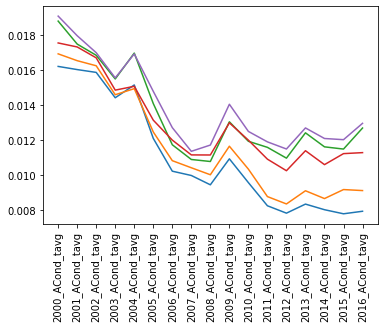

In [19]:
plt.xticks(rotation=90)
for i in range(5):
    plt.plot(acond_tavg.iloc[i])

In [20]:

def glm_fit_per_cell(varname):
    v = master_df.filter(regex=(".*_%s$" % varname))
    years = [int(re.search("(.*)_%s" % varname, s).group(1)) for s in v.columns]
    min_year = min(years)
    max_year = max(years)
    x = np.arange(min_year, max_year + 1).reshape((-1, 1))
    rsqrd = []
    models = []
    for y in v.iloc:
        model = LinearRegression().fit(x, y)
        models.append(model)
        rsqrd.append(model.score(x, y))
    return (models, rsqrd)
    
acond_models, acond_rsqrd = glm_fit_per_cell("ACond_tavg")

(array([2497., 1054.,  915.,  824.,  884.,  937., 1127., 1233., 1172.,
         237.]),
 array([1.39917108e-08, 1.00000013e-01, 2.00000011e-01, 3.00000010e-01,
        4.00000008e-01, 5.00000007e-01, 6.00000006e-01, 7.00000004e-01,
        8.00000003e-01, 9.00000001e-01, 1.00000000e+00]),
 <a list of 10 Patch objects>)

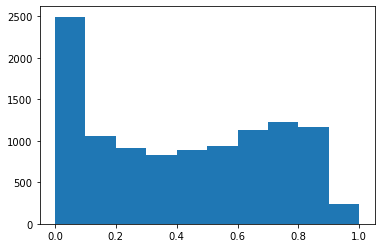

In [21]:
plt.hist(acond_rsqrd)

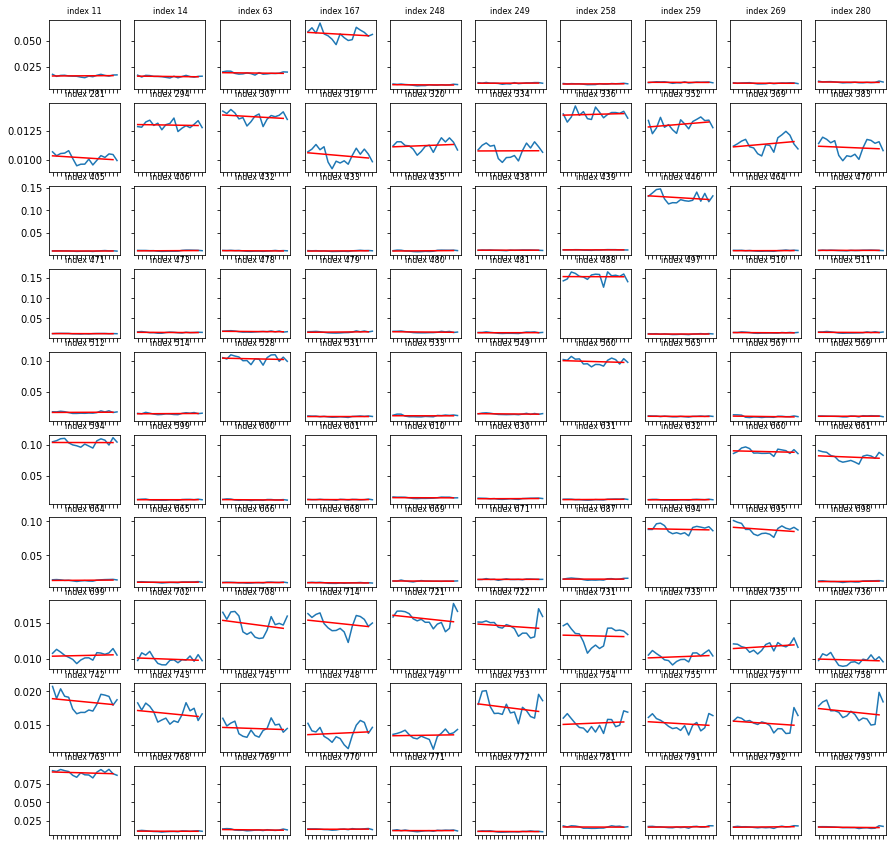

In [22]:
low_scorers = np.where(np.array(acond_rsqrd) < 0.1)[0]
fig, ax = plt.subplots(10, 10, sharex='col', sharey='row', figsize=(15,15))
i = 0
for row in ax:
    for gridplt in row:
        real_idx = low_scorers[i]
        gridplt.set_xticklabels([])
        gridplt.title.set_text('index %d' % real_idx)
        gridplt.title.set_size(8)
        x = np.arange(2000, 2016).reshape((-1, 1))
        y = acond_tavg.iloc[real_idx]
        gridplt.plot(y)
        gridplt.plot([acond_models[real_idx].intercept_ + acond_models[real_idx].coef_[0] * xv for xv in x], 'r')
        i += 1

It is not ideal, but the lines capture the general trend of the variable in each geographical cell.

In [23]:
def project_all_models(df):
    all_vars = [re.search('2000_(.*)', x).group(1) for x in df.filter(regex="2000_.*").columns]
    all_var_models = []
    for v in tqdm(all_vars):
        v_models, _ = glm_fit_per_cell(v)
        all_var_models.append(v_models)
    return all_var_models

def project_cell(df, idx, year, all_models):
    all_vars = [re.search('2000_(.*)', x).group(1) for x in df.filter(regex="2000_.*").columns]
    return [all_models[i][idx].coef_[0] * year + all_models[i][idx].intercept_ for i, v in enumerate(all_vars)]

def project_ssp2_data(df, year):
    # Load GDP/population projections from SSP2
    ssp2_copy = df.copy()
    pop = ssp2_load_population(from_year=year-10, to_year=year+1)
    ssp2_copy = ssp2_copy.merge(pop)
    gdp = ssp2_load_gdp(from_year=year-10, to_year=year+1)
    ssp2_copy = ssp2_copy.merge(gdp)
    return ssp2_copy
    
def project_df(df, year, all_models):
    future_df_spec = {'lon': df['lon'], 'lat': df['lat']}
    future_array = np.array([project_cell(df, i, year, all_models) for i in range(len(df))])
    all_vars = [re.search('2000_(.*)', x).group(1) for x in df.filter(regex="2000_.*").columns]
    for i, var in enumerate(all_vars):
        future_df_spec.update({'%s_%s' % (year, var): future_array[:,i]})
    ssp2_copy = project_ssp2_data(df, year)
    pop_year = 'p2_%s' % year
    gdp_year = 'g2_%s' % year
    future_df_spec.update({gdp_year: ssp2_copy[gdp_year]})
    future_df_spec.update({pop_year: ssp2_copy[pop_year]})
    future_df = dataframe_to_geodataframe(pd.DataFrame(future_df_spec))
    new_df = df.copy()
    return new_df.merge(future_df)

In [24]:
all_var_models = project_all_models(master_df)
future_df = project_df(master_df, 2050, all_var_models)
future_df

100%|██████████| 78/78 [09:41<00:00,  7.46s/it]


,lon,lat,2000_ACond_tavg,2000_Albedo_inst,2000_AvgSurfT_inst,2000_CanopInt_inst,2000_ECanop_tavg,2000_ESoil_tavg,2000_Evap_tavg,2000_LWdown_f_tavg,...,2050_qs,2050_reservoirstor,2050_riverstor,2050_soilmoist,2050_swe,2050_tws,2050_disnat,2050_ncrunnat,g2_2050,p2_2050
0,-179.5,67.5,0.016219,39.998020,261.982452,0.028931,2.330008,15.343687,0.000009,229.330368,...,0.000026,0.0,1.488575,10.169959,161.046802,270.916386,49.303485,0.000027,1.488680e-07,8.299796e-09
1,-178.5,67.5,0.016937,40.676281,262.283844,0.036311,2.233058,15.203341,0.000009,229.323456,...,0.000021,0.0,24.910480,14.462152,127.916474,287.398170,260.792866,0.000023,1.975025e-06,1.041296e-07
2,-177.5,66.5,0.018806,39.602760,263.464081,0.022502,1.618066,16.863810,0.000009,238.398178,...,0.000022,0.0,1.348462,22.316837,158.335091,193.445806,35.564006,0.000023,1.248700e-10,6.272343e-12
3,-177.5,67.5,0.017559,40.260284,263.129944,0.031821,2.382056,14.701731,0.000009,235.138351,...,0.000013,0.0,7.579524,21.924630,129.470585,191.178559,128.054133,0.000013,9.669922e-07,4.876056e-08
4,-176.5,66.5,0.019091,39.242260,263.903259,0.020268,1.530059,16.375177,0.000009,238.532364,...,0.000020,0.0,2.808489,20.629852,144.748873,172.991597,32.058340,0.000020,1.907579e-09,9.607283e-11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10875,178.5,66.5,0.015414,39.112247,263.983429,0.027007,1.653442,18.262630,0.000010,237.184082,...,0.000025,0.0,2.032639,18.606742,225.869671,302.019074,67.927078,0.000025,1.271202e-04,6.943921e-06
10876,178.5,67.5,0.014983,40.879303,260.781891,0.017122,1.584615,15.298200,0.000009,226.266846,...,0.000020,0.0,2.527283,27.676480,331.233438,482.990880,43.068518,0.000022,9.395860e-05,5.354371e-06
10877,178.5,68.5,0.013615,-796.932922,259.243500,0.017424,1.510876,12.922237,0.000008,224.636765,...,0.000011,0.0,1.343047,8.194586,151.538912,377.194433,18.484051,0.000013,2.066604e-05,1.139748e-06
10878,179.5,66.5,0.015795,39.452206,263.995148,0.018649,1.290685,19.071337,0.000010,236.835693,...,0.000026,0.0,24.616773,28.492540,233.952552,304.293173,145.065752,0.000026,4.255106e-05,2.355910e-06


In [26]:
future_df.filter(regex=".*2050.*")

,2050_ACond_tavg,2050_Albedo_inst,2050_AvgSurfT_inst,2050_CanopInt_inst,2050_ECanop_tavg,2050_ESoil_tavg,2050_Evap_tavg,2050_LWdown_f_tavg,2050_Lwnet_tavg,2050_Psurf_f_inst,...,2050_qs,2050_reservoirstor,2050_riverstor,2050_soilmoist,2050_swe,2050_tws,2050_disnat,2050_ncrunnat,g2_2050,p2_2050
0,-0.013869,-925.042221,250.929574,0.029180,3.752627,24.536195,0.000012,189.540770,-44.851951,94761.175551,...,0.000026,0.0,1.488575,10.169959,161.046802,270.916386,49.303485,0.000027,1.488680e-07,8.299796e-09
1,-0.011389,72.577574,254.058168,0.022557,4.405940,25.275895,0.000013,198.141227,-47.528701,101079.139476,...,0.000021,0.0,24.910480,14.462152,127.916474,287.398170,260.792866,0.000023,1.975025e-06,1.041296e-07
2,-0.003665,33.197989,258.834864,0.016525,3.227895,26.701101,0.000013,202.450659,-56.975382,97894.578929,...,0.000022,0.0,1.348462,22.316837,158.335091,193.445806,35.564006,0.000023,1.248700e-10,6.272343e-12
3,-0.004645,-1109.564013,257.299404,0.016314,3.921367,25.212307,0.000013,201.360342,-54.558425,101690.394761,...,0.000013,0.0,7.579524,21.924630,129.470585,191.178559,128.054133,0.000013,9.669922e-07,4.876056e-08
4,-0.002767,32.830386,259.587475,0.023407,3.655577,25.551612,0.000013,203.671407,-58.685369,100679.494830,...,0.000020,0.0,2.808489,20.629852,144.748873,172.991597,32.058340,0.000020,1.907579e-09,9.607283e-11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10875,-0.004671,32.436099,258.269015,0.023779,4.567940,32.097315,0.000017,203.560904,-55.888015,99990.368107,...,0.000025,0.0,2.032639,18.606742,225.869671,302.019074,67.927078,0.000025,1.271202e-04,6.943921e-06
10876,-0.014454,-226.978261,255.300737,0.021937,3.521912,32.012160,0.000015,194.714345,-55.325165,96549.072381,...,0.000020,0.0,2.527283,27.676480,331.233438,482.990880,43.068518,0.000022,9.395860e-05,5.354371e-06
10877,-0.010815,-803.639743,253.347366,0.032414,4.313263,28.691743,0.000015,191.443827,-53.178857,99531.502872,...,0.000011,0.0,1.343047,8.194586,151.538912,377.194433,18.484051,0.000013,2.066604e-05,1.139748e-06
10878,-0.007007,30.679041,261.504620,0.026342,3.783810,33.666969,0.000016,215.281378,-55.785559,106552.358571,...,0.000026,0.0,24.616773,28.492540,233.952552,304.293173,145.065752,0.000026,4.255106e-05,2.355910e-06


# PCA 2050

In [56]:
df = future_df.filter(regex=".*2050.*")

In [57]:
# Display max columns & rows for viewing purposes
pd.set_option('display.max_columns', 2203)
pd.set_option('display.max_rows', 2203)

# Reduce decimal points to 2
pd.options.display.float_format = '{:,.2f}'.format

In [58]:
print('Dimensions of the dataset:',df.shape)

Dimensions of the dataset: (10880, 80)


In [59]:
# New df with variables relating to 2050 only + lon, lat, geometry
var_2050 = future_df.loc[:, future_df.columns.str.contains('2050')]
geom = master_df[['lon','lat','geometry']]
df_geo = pd.concat([geom, var_2050], axis=1)
df_geo = pd.DataFrame(df_geo)
df_geo.shape

(10880, 83)

In [60]:
# Treating missing values (-9999)

df_geo.replace(-9999, np.NaN, inplace = True)

In [61]:
df_geo.isna().sum()

lon                             0
lat                             0
geometry                        0
2050_ACond_tavg                32
2050_Albedo_inst               32
2050_AvgSurfT_inst             32
2050_CanopInt_inst             32
2050_ECanop_tavg               32
2050_ESoil_tavg                32
2050_Evap_tavg                 32
2050_LWdown_f_tavg              2
2050_Lwnet_tavg                32
2050_Psurf_f_inst               2
2050_Qair_f_inst                2
2050_Qg_tavg                   32
2050_Qh_tavg                   32
2050_Qle_tavg                  32
2050_Qs_acc                    32
2050_Qsb_acc                   32
2050_Qsm_acc                   32
2050_Rainf_f_tavg               2
2050_Rainf_tavg                32
2050_SWE_inst                  32
2050_SWdown_f_tavg              2
2050_SnowDepth_inst            32
2050_SnowT_tavg                32
2050_Snowf_tavg                32
2050_SoilMoist_P_inst          32
2050_SoilMoist_RZ_inst         32
2050_SoilMoist

In [62]:
print('Dimensions of the dataset:', df_geo.shape)
print('Dimensions after removing rows:', df_geo.dropna(axis=0).shape)

Dimensions of the dataset: (10880, 83)
Dimensions after removing rows: (10848, 83)


In [63]:
df_geo = df_geo.dropna(axis=0)

In [64]:
df_geo.dtypes

lon                             float64
lat                             float64
geometry                       geometry
2050_ACond_tavg                 float64
2050_Albedo_inst                float64
2050_AvgSurfT_inst              float64
2050_CanopInt_inst              float64
2050_ECanop_tavg                float64
2050_ESoil_tavg                 float64
2050_Evap_tavg                  float64
2050_LWdown_f_tavg              float64
2050_Lwnet_tavg                 float64
2050_Psurf_f_inst               float64
2050_Qair_f_inst                float64
2050_Qg_tavg                    float64
2050_Qh_tavg                    float64
2050_Qle_tavg                   float64
2050_Qs_acc                     float64
2050_Qsb_acc                    float64
2050_Qsm_acc                    float64
2050_Rainf_f_tavg               float64
2050_Rainf_tavg                 float64
2050_SWE_inst                   float64
2050_SWdown_f_tavg              float64
2050_SnowDepth_inst             float64


In [65]:
# Scaling the data (normalising floats)
# If we fail to do it, then the features with numerical values far greater than others will tend to dominate.

# Keeping floats only and turn them into ndarrays with DataFrame.values
x = df_geo.iloc[:, 3:].values

# Standardization
x = StandardScaler().fit_transform(x)
             
# back to dataframe
df = pd.DataFrame(x, columns=list(df_geo.iloc[:, 3:].columns))

# Quick look 
df.sample(10)

,2050_ACond_tavg,2050_Albedo_inst,2050_AvgSurfT_inst,2050_CanopInt_inst,2050_ECanop_tavg,2050_ESoil_tavg,2050_Evap_tavg,2050_LWdown_f_tavg,2050_Lwnet_tavg,2050_Psurf_f_inst,2050_Qair_f_inst,2050_Qg_tavg,2050_Qh_tavg,2050_Qle_tavg,2050_Qs_acc,2050_Qsb_acc,2050_Qsm_acc,2050_Rainf_f_tavg,2050_Rainf_tavg,2050_SWE_inst,2050_SWdown_f_tavg,2050_SnowDepth_inst,2050_SnowT_tavg,2050_Snowf_tavg,2050_SoilMoist_P_inst,2050_SoilMoist_RZ_inst,2050_SoilMoist_S_inst,2050_SoilTMP0_10cm_inst,2050_SoilTMP10_29cm_inst,2050_SoilTMP144_295cm_inst,2050_SoilTMP295_1295cm_inst,2050_SoilTMP29_68cm_inst,2050_SoilTMP68_144cm_inst,2050_Swnet_tavg,2050_TVeg_tavg,2050_TWS_inst,2050_Tair_f_inst,2050_Wind_f_inst,2050_anag,2050_anas,2050_atotuse,2050_canopystor,2050_dis,2050_evap,2050_glolakestor,2050_glowetlandstor,2050_groundwstor,2050_loclakestor,2050_locwetlandstor,2050_ncrun,2050_pdomuse,2050_pdomww,2050_pgwuse,2050_pgwww,2050_pinduse,2050_pindww,2050_pirruse,2050_pirrww,2050_plivuse,2050_pnag,2050_pnas,2050_potevap,2050_precmon,2050_ptotuse,2050_ptotww,2050_qg,2050_ql,2050_qr,2050_qrdif,2050_qrswb,2050_qs,2050_reservoirstor,2050_riverstor,2050_soilmoist,2050_swe,2050_tws,2050_disnat,2050_ncrunnat,g2_2050,p2_2050
3706,-0.51,-4.22,-2.00,-0.50,-0.85,-1.23,-0.74,-1.63,1.40,0.18,-1.36,0.65,-1.29,-1.01,4.50,0.11,5.48,1.39,-0.83,3.37,-1.70,4.62,-2.00,7.80,2.33,3.88,3.40,-1.46,-1.45,-1.50,-1.64,-1.44,-1.45,-2.04,-0.60,3.03,-1.85,-0.10,-0.03,-0.20,-0.23,-0.74,-0.08,-0.89,-0.05,-0.18,0.07,0.16,-0.36,0.64,-0.24,-0.28,-0.22,-0.23,-0.10,-0.11,-0.24,-0.23,-0.40,0.01,-0.21,-1.37,-0.10,-0.24,-0.24,-0.54,0.70,-0.54,-0.53,-0.13,1.30,-0.08,-0.13,0.12,-0.14,-0.14,-0.09,0.62,-0.20,-0.22
132,-0.46,0.15,-1.31,0.89,0.19,0.27,0.17,-1.00,1.29,0.17,-0.79,-1.21,-0.76,0.19,0.45,0.13,2.19,0.83,0.09,0.76,-1.00,1.16,-1.31,2.57,1.73,0.94,1.09,-0.72,-0.72,-0.66,-0.76,-0.71,-0.67,-0.92,0.08,1.72,-1.14,-0.58,-0.02,-0.20,-0.23,0.50,-0.02,-0.44,-0.05,0.17,0.11,0.04,2.85,0.31,-0.22,-0.26,-0.21,-0.22,-0.10,-0.11,-0.24,-0.23,-0.38,0.01,-0.21,-0.89,-0.10,-0.24,-0.24,-0.04,0.24,-0.03,0.04,-0.13,0.32,-0.08,-0.04,-0.42,-0.16,-0.13,-0.02,0.29,-0.19,-0.21
380,-0.52,0.15,-1.12,-0.05,-0.23,-0.51,-0.27,-0.97,0.63,-0.44,-0.69,-0.43,-0.57,-0.28,0.15,0.11,0.72,-0.32,-0.48,0.28,-0.99,0.43,-1.12,0.57,-0.59,-0.46,-0.26,-0.70,-0.71,-0.78,-0.76,-0.72,-0.75,-0.96,-0.06,-0.43,-0.89,-0.85,-0.03,-0.20,-0.23,0.20,-0.12,-0.78,-0.05,-0.26,0.08,-0.25,0.27,-0.02,-0.24,-0.28,-0.22,-0.23,-0.10,-0.11,-0.24,-0.23,-0.40,0.01,-0.21,-0.89,-0.54,-0.24,-0.24,-0.42,-0.04,-0.43,-0.40,-0.13,0.17,-0.08,-0.13,-0.71,-0.15,-0.16,-0.12,-0.04,-0.20,-0.22
5990,1.09,0.12,-0.32,0.85,0.51,-0.74,0.17,-0.77,-1.30,0.90,-0.21,-1.97,-1.39,0.18,-0.13,-0.17,0.24,0.01,0.03,-0.06,-0.90,-0.16,-0.31,-0.07,0.41,-0.55,-0.40,-0.51,-0.49,-0.32,-0.11,-0.45,-0.39,-0.63,0.54,0.34,-0.38,-0.07,-0.03,-0.19,-0.22,0.36,-0.06,-0.55,-0.05,-0.17,0.20,0.05,-0.35,0.50,-0.16,-0.22,-0.21,-0.22,-0.10,-0.11,-0.24,-0.23,-0.40,0.01,-0.20,-0.91,-0.06,-0.24,-0.24,1.09,0.53,1.10,1.31,-0.13,0.02,-0.08,-0.06,0.13,-0.15,-0.15,-0.06,0.48,-0.19,-0.21
9430,0.24,0.14,-0.87,0.59,0.51,-0.31,0.11,-0.83,0.42,0.55,-0.71,-2.11,-0.93,0.07,0.20,0.11,0.51,0.21,0.04,0.27,-1.08,0.39,-0.87,0.59,-0.10,0.22,0.40,-0.61,-0.60,-0.44,-0.23,-0.57,-0.53,-0.90,0.12,-0.00,-0.89,-0.45,-0.03,-0.20,-0.23,0.22,0.04,-0.61,-0.05,-0.11,0.08,-0.35,-0.35,0.29,-0.23,-0.28,-0.22,-0.22,-0.10,-0.11,-0.24,-0.23,-0.41,0.01,-0.21,-0.81,-0.22,-0.24,-0.24,-0.41,0.30,-0.41,-0.38,-0.13,0.65,-0.08,0.02,-0.41,-0.15,-0.16,0.04,0.27,-0.20,-0.22
10108,0.20,0.12,1.23,-0.53,-0.73,-1.40,-1.09,1.02,-1.42,0.51,0.27,0.21,2.01,-1.06,-0.16,0.11,-0.35,-1.14,-0.97,-0.02,1.31,-0.13,1.23,-0.53,-0.99,-0.93,-1.03,1.26,1.26,1.27,1.22,1.27,1.27,1.32,-0.62,-0.86,1.22,1.87,-0.03,-0.19,-0.23,-0.74,-0.11,-0.07,-0.05,-0.26,0.08,-0.35,-0.36,0.01,-0.24,-0.28,-0.22,-0.23,-0.10,-0.11,-0.24,-0.23,-0.37,0.01,-0.20,2.04,-0.04,-0.24,-0.24,-0.34,0.01,-0.33,-0.29,-0.13,0.18,-0.08,-0.10,-0.72,-0.16,-0.17,-0.11,-0.01,-0.20,-0.22
10634,-0.57,0.15,-1.56,0.42,-0.13,0

In [72]:
df.describe()

,2050_ACond_tavg,2050_Albedo_inst,2050_AvgSurfT_inst,2050_CanopInt_inst,2050_ECanop_tavg,2050_ESoil_tavg,2050_Evap_tavg,2050_LWdown_f_tavg,2050_Lwnet_tavg,2050_Psurf_f_inst,2050_Qair_f_inst,2050_Qg_tavg,2050_Qh_tavg,2050_Qle_tavg,2050_Qs_acc,2050_Qsb_acc,2050_Qsm_acc,2050_Rainf_f_tavg,2050_Rainf_tavg,2050_SWE_inst,2050_SWdown_f_tavg,2050_SnowDepth_inst,2050_SnowT_tavg,2050_Snowf_tavg,2050_SoilMoist_P_inst,2050_SoilMoist_RZ_inst,2050_SoilMoist_S_inst,2050_SoilTMP0_10cm_inst,2050_SoilTMP10_29cm_inst,2050_SoilTMP144_295cm_inst,2050_SoilTMP295_1295cm_inst,2050_SoilTMP29_68cm_inst,2050_SoilTMP68_144cm_inst,2050_Swnet_tavg,2050_TVeg_tavg,2050_TWS_inst,2050_Tair_f_inst,2050_Wind_f_inst,2050_anag,2050_anas,2050_atotuse,2050_canopystor,2050_dis,2050_evap,2050_glolakestor,2050_glowetlandstor,2050_groundwstor,2050_loclakestor,2050_locwetlandstor,2050_ncrun,2050_pdomuse,2050_pdomww,2050_pgwuse,2050_pgwww,2050_pinduse,2050_pindww,2050_pirruse,2050_pirrww,2050_plivuse,2050_pnag,2050_pnas,2050_potevap,2050_precmon,2050_ptotuse,2050_ptotww,2050_qg,2050_ql,2050_qr,2050_qrdif,2050_qrswb,2050_qs,2050_reservoirstor,2050_riverstor,2050_soilmoist,2050_swe,2050_tws,2050_disnat,2050_ncrunnat,g2_2050,p2_2050
count,"10,848.00","10,848.00","10,848.00","10,848.00","10,848.00","10,848.00","10,848.00","10,848.00","10,848.00","10,848.00","10,848.00","10,848.00","10,848.00","10,848.00","10,848.00","10,848.00","10,848.00","10,848.00","10,848.00","10,848.00","10,848.00","10,848.00","10,848.00","10,848.00","10,848.00","10,848.00","10,848.00","10,848.00","10,848.00","10,848.00","10,848.00","10,848.00","10,848.00","10,848.00","10,848.00","10,848.00","10,848.00","10,848.00","10,848.00","10,848.00","10,848.00","10,848.00","10,848.00","10,848.00","10,848.00","10,848.00","10,848.00","10,848.00","10,848.00","10,848.00","10,848.00","10,848.00","10,848.00","10,848.00","10,848.00","10,848.00","10,848.00","10,848.00","10,848.00","10,848.00","10,848.00","10,848.00","10,848.00","10,848.00","10,848.00","10,848.00","10,848.00","10,848.00","10,848.00","10,848.00","10,848.00","10,848.00","10,848.00","10,848.00","10,848.00","10,848.00","10,848.00","10,848.00","10,848.00","10,848.00"
mean,-0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-0.00,-0.00,0.00,-0.00,-0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-0.00,0.00,-0.00,0.00,-0.00,-0.00,0.00,0.00,0.00,-0.00,0.00,0.00,-0.00,0.00,-0.00,-0.00,-0.00,-0.00,0.00,-0.00,-0.00,-0.00,0.00,0.00,0.00,-0.00,-0.00,-0.00,0.00,0.00,0.00,-0.00,0.00,-0.00,-0.00,-0.00,-0.00,0.00,-0.00,-0.00,0.00,-0.00,-0.00,0.00,-0.00,0.00,0.00,-0.00,-0.00,-0.00,-0.00,-0.00,0.00,-0.00,0.00,0.00,-0.00,-0.00
std,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00
min,-9.55,-5.68,-2.89,-5.98,-2.17,-3.84,-1.75,-2.34,-6.80,-5.24,-2.79,-4.07,-5.47,-1.72,-11.55,-35.52,-6.94,-2.71,-2.37,-13.84,-2.10,-12.76,-2.89,-12.83,-4.38,-5.72,-5.38,-4.36,-4.39,-4.93,-5.72,-4.46,-4.63,-2.54,-1.85,-6.91,-2.75,-3.70,-19.61,-3.35,-2.22,-1.37,-0.19,-1.84,-60.34,-0.74,-32.41,-5.22,-0.67,-13.83,-17.91,-23.02,-2.73,-2.32,-1.74,-21.52,-2.48,-2.53,-5.30,-21.91,-2.98,-1.53,-1.41,-2.12,-8.28,-1.47,-1.49,-1.66,-1.23,-2.35,-1.64,-0.53,-0.19,-0.91,-0.25,-1.56,-0.20,-18.36,-0.20,-0.22
25%,-0.43,0.11,-0.79,-0.52,-0.66,-0.70,-0.64,-0.86,-0.58,-0.31,-0.71,-0.50,-0.68,-0.65,-0.10,0.11,-0.35,-0.67,-0.64,-0.02,-0.88,-0.13,-0.80,-0.53,-0.59,-0.44,-0.60,-0.63,-0.63,-0.61,-0.58,-0.63,-0.62,-0.79,-0.60,-0.51,-0.80,-0.63,-0.03,-0.20,-0.23,-0.73,-0.13,-0.73,-0.05,-0.26,0.06,-0.35,-0.36,-0.56,-0.24,-0.28,-0.22,-0.23,-0.10,-0.11,-0.24,-0.23,-0.40,0.01,-0.21,-0.86,-0.59,-0.24,-0.24,-0.55,-0.61,-0.55,-0.55,-0.13,-0.62,-0.08,-0.13,-0.69,-0.16,-0.17,-0.13,-0.56,-0.20,-0.22
50%,-

In [69]:
# Scaling and centering the data + turning it into np.ndarry
scaled_data = preprocessing.scale(df)
# PCA
pca = PCA()
pca.fit(scaled_data)
pca_data = pca.transform(scaled_data)

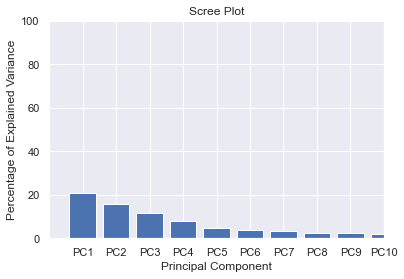

In [70]:
# Scree plot

# % of variation each PC accounts for:
per_var = np.round(pca.explained_variance_ratio_*100, decimals=1)
labels =['PC' + str(x) for x in range(1, len(per_var)+1)]

plt.bar(x=range(1, len(per_var)+1), height=per_var, tick_label=labels)
plt.ylabel('Percentage of Explained Variance')
plt.xlabel('Principal Component')
plt.title('Scree Plot')
plt.ylim([0,100])
plt.xlim([0,10])
plt.show()

In [74]:
# Creating a PC plot
# First we put the new coordinates created by pca.transform(scaled.data) into a nice matrix, where the rows have sample labels and the columns have PC labels
pca_df = pd.DataFrame(pca_data, columns=labels)
pca_df["geometry"] = df_geo["geometry"] # adding back geometric locations
pca_df.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14,PC15,PC16,PC17,PC18,PC19,PC20,PC21,PC22,PC23,PC24,PC25,PC26,PC27,PC28,PC29,PC30,PC31,PC32,PC33,PC34,PC35,PC36,PC37,PC38,PC39,PC40,PC41,PC42,PC43,PC44,PC45,PC46,PC47,PC48,PC49,PC50,PC51,PC52,PC53,PC54,PC55,PC56,PC57,PC58,PC59,PC60,PC61,PC62,PC63,PC64,PC65,PC66,PC67,PC68,PC69,PC70,PC71,PC72,PC73,PC74,PC75,PC76,PC77,PC78,PC79,PC80,geometry
0,-3.85,-4.25,1.30,-2.18,0.23,-1.07,0.17,3.15,-0.38,0.05,0.71,-0.43,-0.77,-0.82,-0.05,-0.03,0.21,-0.44,0.13,-0.36,0.24,1.38,-0.64,0.79,0.44,-0.07,-0.74,-0.11,-0.82,0.37,0.37,-0.99,-0.56,0.13,0.07,-0.93,0.49,-0.12,0.28,0.16,-0.12,-0.22,0.16,-0.38,0.28,0.01,0.30,-0.21,0.19,0.05,-0.04,-0.05,-0.09,-0.08,0.06,-0.03,-0.15,-0.00,-0.01,-0.06,-0.08,-0.01,0.01,-0.01,0.00,-0.00,-0.02,-0.00,0.00,0.00,0.00,0.00,0.00,0.00,-0.00,0.00,-0.00,-0.00,-0.00,-0.00,POINT (-179.50000 67.50000)
1,-3.49,-3.68,1.10,-2.25,0.16,-0.63,0.08,2.23,-0.18,-0.18,0.52,0.03,-1.03,-0.04,-1.12,0.17,0.57,-0.78,-0.26,0.08,-0.24,1.12,-0.51,1.04,0.14,-0.22,-0.17,-0.11,-0.77,-0.20,0.34,-0.68,-0.60,0.13,0.40,-0.61,0.32,-0.05,0.15,0.05,-0.16,-0.04,0.14,-0.28,0.15,0.02,0.03,-0.09,0.10,0.04,0.01,0.10,-0.02,0.02,0.07,-0.02,-0.12,-0.00,0.00,-0.06,-0.03,0.02,0.00,-0.01,-0.00,0.00,-0.02,-0.00,0.00,-0.00,-0.00,-0.00,-0.00,-0.00,0.00,0.00,-0.00,-0.00,0.00,-0.00,POINT (-178.50000 67.50000)
2,-3.26,-3.03,0.83,-1.12,0.13,-0.94,0.18,2.26,-0.19,-0.21,0.58,0.31,-0.68,-0.13,-0.77,0.40,1.01,-0.20,-0.34,0.38,-0.41,1.00,0.07,0.80,0.29,-0.09,-0.28,0.24,-0.26,-0.62,0.31,-0.51,-0.20,0.01,0.61,-0.85,0.35,0.16,0.53,0.07,0.29,0.12,0.14,-0.03,-0.13,-0.03,0.10,-0.09,0.09,0.03,-0.07,0.10,-0.05,0.02,0.06,0.00,-0.03,-0.00,0.01,-0.06,-0.04,0.01,0.00,-0.00,0.00,-0.00,-0.02,-0.00,0.00,0.00,-0.00,-0.00,0.00,-0.00,-0.00,0.00,-0.00,-0.00,-0.00,-0.00,POINT (-177.50000 66.50000)
3,-3.73,-2.68,0.98,-2.26,0.10,-0.30,0.25,1.15,-0.15,0.19,0.39,-0.09,0.27,-1.29,0.19,0.28,0.25,0.30,0.12,-0.29,0.20,1.11,-0.21,0.31,0.38,0.17,-0.69,-0.37,-0.78,0.10,0.59,-0.64,-0.47,0.10,0.48,-0.53,0.01,0.27,0.20,-0.05,0.12,0.06,0.02,-0.03,0.04,0.00,-0.00,0.02,0.22,-0.00,-0.01,0.21,-0.09,0.03,0.01,-0.00,-0.06,0.00,0.01,-0.08,-0.03,0.03,-0.00,0.01,0.00,-0.01,-0.01,-0.00,0.00,0.00,-0.00,0.00,0.00,-0.00,0.00,0.00,-0.00,0.00,0.00,-0.00,POINT (-177.50000 67.50000)
4,-3.40,-2.42,0.66,-0.39,0.09,-0.78,-0.06,1.94,-0.15,-0.28,0.29,0.42,-0.63,0.01,-1.21,0.49,1.07,-0.04,-0.31,0.32,-0.37,1.32,0.36,0.79,0.02,-0.00,-0.33,0.11,-0.29,-1.02,0.39,-0.39,-0.02,-0.03,0.90,-1.04,0.12,0.09,0.60,-0.01,0.36,0.16,0.21,-0.13,-0.06,-0.03,0.09,-0.04,0.13,0.04,-0.06,0.13,-0.06,0.09,0.03,0.00,-0.03,-0.00,0.01,-0.06,-0.02,0.03,0.00,0.00,0.00,0.00,-0.02,-0.00,-0.00,-0.00,0.00,0.00,0.00,0.00,-0.00,0.00,-0.00,-0.00,-0.00,-0.00,POINT (-176.50000 66.50000)


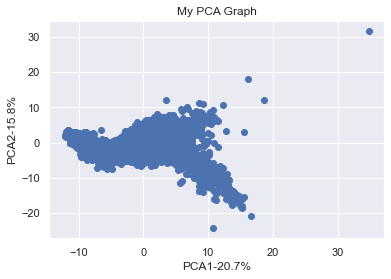

In [75]:
# Scatter plot

plt.scatter(pca_df.PC1, pca_df.PC2)
plt.title('My PCA Graph')
plt.xlabel('PCA1-{0}%'.format(per_var[0]))
plt.ylabel('PCA2-{0}%'.format(per_var[1]))

# for sample in pca_df.index: plt.annotate(sample, (pca_df.PC1.loc[sample], pca_df.PC2.loc[sample]))

plt.show()

# points that cluster together tend to be similar

In [76]:
column_names=list(df.iloc[:, 3:].columns)

In [77]:
# Which variable had the biggest effect on separating the observations? => Loading scores on PCA 1

loading_scores = pd.Series(pca.components_[0])
sorted_loading_scores = loading_scores.abs().sort_values(ascending=False)
top_10_vars = sorted_loading_scores[0:10].index.values
print(loading_scores[top_10_vars])

7    0.22
36   0.21
31   0.20
28   0.20
27   0.20
32   0.20
2    0.20
22   0.20
10   0.20
29   0.20
dtype: float64


In [79]:
pd.DataFrame(column_names).loc[[7, 36, 31, 28, 27, 32, 2, 22, 10, 29]]

,0
7,2050_Qair_f_inst
36,2050_anas
31,2050_TVeg_tavg
28,2050_SoilTMP29_68cm_inst
27,2050_SoilTMP295_1295cm_inst
32,2050_TWS_inst
2,2050_ESoil_tavg
22,2050_SoilMoist_RZ_inst
10,2050_Qle_tavg
29,2050_SoilTMP68_144cm_inst


## PCA on data grouped by country 

In [80]:
# importing SSP2 population data
# adding back ISO column
# px - Longitude 
# py - Latitude 

pop = pd.read_csv("/Users/lilivandermeersch/MDA/project/data/gdp_ssp2.csv")
ISO = pop[['px','py','ISO3']]
ISO = ISO.rename(columns={"px":"lon", "py":"lat"})

# Turning into WKT
ISO = dataframe_to_geodataframe(ISO)

# turning ISO into a GeoDataFrame from WKT format
gISO = geopandas.GeoDataFrame(ISO, geometry='geometry')
print(gISO.head())

      lon    lat ISO3                      geometry
0 -179.96 -16.38  FJI  POINT (-179.95988 -16.38242)
1 -179.94 -15.74  FJI  POINT (-179.94336 -15.73900)
2 -179.90 -16.79  FJI  POINT (-179.90168 -16.78760)
3 -179.86 -19.00  FJI  POINT (-179.86174 -19.00430)
4 -179.83 -18.96  FJI  POINT (-179.82871 -18.95897)


In [84]:
# Turning df_geo into GeoDataFrames from WKT format
gdf = geopandas.GeoDataFrame(df_geo, geometry='geometry')
print(gdf.head())

      lon   lat                     geometry  2050_ACond_tavg  \
0 -179.50 67.50  POINT (-179.50000 67.50000)            -0.01   
1 -178.50 67.50  POINT (-178.50000 67.50000)            -0.01   
2 -177.50 66.50  POINT (-177.50000 66.50000)            -0.00   
3 -177.50 67.50  POINT (-177.50000 67.50000)            -0.00   
4 -176.50 66.50  POINT (-176.50000 66.50000)            -0.00   

   2050_Albedo_inst  2050_AvgSurfT_inst  2050_CanopInt_inst  2050_ECanop_tavg  \
0           -925.04              250.93                0.03              3.75   
1             72.58              254.06                0.02              4.41   
2             33.20              258.83                0.02              3.23   
3         -1,109.56              257.30                0.02              3.92   
4             32.83              259.59                0.02              3.66   

   2050_ESoil_tavg  2050_Evap_tavg  2050_LWdown_f_tavg  2050_Lwnet_tavg  \
0            24.54            0.00             

In [87]:
# Spatial join

world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
cities = geopandas.read_file(geopandas.datasets.get_path('naturalearth_cities'))
countries = world[['geometry', 'name']]
countries = countries.rename(columns={'name':'country'})

df_2050 = geopandas.sjoin(gdf, countries, how="inner", op='intersects')
df_2050.sample(10)

,lon,lat,geometry,2050_ACond_tavg,2050_Albedo_inst,2050_AvgSurfT_inst,2050_CanopInt_inst,2050_ECanop_tavg,2050_ESoil_tavg,2050_Evap_tavg,2050_LWdown_f_tavg,2050_Lwnet_tavg,2050_Psurf_f_inst,2050_Qair_f_inst,2050_Qg_tavg,2050_Qh_tavg,2050_Qle_tavg,2050_Qs_acc,2050_Qsb_acc,2050_Qsm_acc,2050_Rainf_f_tavg,2050_Rainf_tavg,2050_SWE_inst,2050_SWdown_f_tavg,2050_SnowDepth_inst,2050_SnowT_tavg,2050_Snowf_tavg,2050_SoilMoist_P_inst,2050_SoilMoist_RZ_inst,2050_SoilMoist_S_inst,2050_SoilTMP0_10cm_inst,2050_SoilTMP10_29cm_inst,2050_SoilTMP144_295cm_inst,2050_SoilTMP295_1295cm_inst,2050_SoilTMP29_68cm_inst,2050_SoilTMP68_144cm_inst,2050_Swnet_tavg,2050_TVeg_tavg,2050_TWS_inst,2050_Tair_f_inst,2050_Wind_f_inst,2050_anag,2050_anas,2050_atotuse,2050_canopystor,2050_dis,2050_evap,2050_glolakestor,2050_glowetlandstor,2050_groundwstor,2050_loclakestor,2050_locwetlandstor,2050_ncrun,2050_pdomuse,2050_pdomww,2050_pgwuse,2050_pgwww,2050_pinduse,2050_pindww,2050_pirruse,2050_pirrww,2050_plivuse,2050_pnag,2050_pnas,2050_potevap,2050_precmon,2050_ptotuse,2050_ptotww,2050_qg,2050_ql,2050_qr,2050_qrdif,2050_qrswb,2050_qs,2050_reservoirstor,2050_riverstor,2050_soilmoist,2050_swe,2050_tws,2050_disnat,2050_ncrunnat,g2_2050,p2_2050,index_right,country
64,-156.50,60.50,POINT (-156.50000 60.50000),0.00,29.20,267.61,0.07,7.81,23.53,0.00,250.99,-42.70,"102,106.22",0.00,-2.45,1.41,31.96,0.13,0.02,0.08,0.00,0.00,7.91,94.61,0.07,267.61,0.00,"2,445.06",434.95,8.03,273.32,273.27,274.62,273.16,273.31,274.00,73.20,0.62,"2,453.03",270.84,0.92,0.00,-0.00,0.00,0.07,92.71,0.00,0.00,0.00,51.40,10.36,419.68,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,18.91,8.72,25.81,534.94,92.71,0.00,0.00,0.00,4,United States of America
3966,-2.50,40.50,POINT (-2.50000 40.50000),0.01,18.01,283.66,0.03,4.97,36.87,0.00,304.42,-56.06,"84,718.92",0.00,0.19,25.96,52.68,0.01,0.00,0.01,0.00,0.00,0.22,162.86,0.00,283.62,0.00,"1,644.84",267.26,5.39,283.62,283.58,283.17,282.47,283.50,283.37,135.62,10.84,"1,645.09",284.77,2.62,0.00,0.00,0.00,0.06,15.90,0.00,0.00,0.00,18.94,-1.09,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-68.23,0.70,72.20,0.06,22.65,22.30,0.00,1.00,0.03,132,Spain
7099,72.50,43.50,POINT (72.50000 43.50000),0.02,30.24,284.22,0.01,2.94,23.27,0.00,302.75,-64.71,"93,783.65",0.00,0.55,21.01,44.40,0.03,0.00,0.06,0.00,0.00,8.53,177.75,0.04,284.19,0.00,473.65,102.57,2.33,286.56,286.38,286.04,286.21,286.20,286.05,135.47,18.20,482.20,286.89,5.45,-0.00,0.00,0.00,0.06,1.91,0.00,0.00,0.00,0.74,-0.19,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-0.00,-0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.12,46.40,1.84,48.97,1.93,0.00,0.03,0.00,5,Kazakhstan
8871,109.50,38.50,POINT (109.50000 38.50000),0.01,25.13,288.20,0.00,2.37,30.48,0.00,325.29,-52.62,"87,871.76",0.00,0.69,36.22,35.94,0.02,-0.00,0.00,0.00,0.00,0.30,164.78,0.00,288.19,0.00,375.80,76.29,1.65,287.98,287.77,287.08,286.55,287.48,287.26,126.27,3.10,376.11,289.10,5.74,-0.00,0.00,0.00,0.05,10.22,0.00,0.00,0.00,13.34,-13.90,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.50,48.51,1.45,49.95,16.45,0.00,2.28,0.07,139,China
6723,61.50,38.50,POINT (61.50000 38.50000),0.02,26.94,294.39,0.00,0.35,7.58,0.00,331.14,-79.84,"100,441.17",0.00,0.19,42.36,20.56,0.02,0.00,-0.00,0.00,0.00,-0.02,191.99,-0.00,294.35,-0.00,197.39,48.66,0.64,294.09,294.05,294.03,294.15,294.01,294.00,142.85,12.64,197.38,294.51,6.29,-0.00,0.00,0.00,0.01,-15.76,0.00,0.00,0.00,1.29,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-0.71,2.83,-0.11,3.30,7.89,0.00,0.02,0.00,106,Turkmenistan
3083,-51.50,80.50,POINT (-51.50000 80.50000),0.02,"-2,471.69",252.43,0.00,0.10,-1.66,0.00,176.83,-52.91,"86,262.02",0.00,0.96,5.41,-1.56,-0.01,0.00,-0.01,0.00,0.00,7.06,92.37,0.08,252.42,

In [91]:
# Grouping by country - average

df_group = df_2050.groupby('country')
df_group.size()

country
Afghanistan                   42
Algeria                      172
Angola                        72
Argentina                    206
Australia                    596
Austria                        2
Azerbaijan                     3
Bangladesh                     2
Belarus                       15
Benin                          1
Bolivia                       66
Bosnia and Herz.               1
Botswana                      30
Brazil                       606
Bulgaria                       3
Burkina Faso                   9
Cambodia                       6
Cameroon                      18
Canada                      1104
Central African Rep.          29
Chad                          81
Chile                         16
China                        819
Colombia                      66
Congo                          9
Cuba                           1
Czechia                        1
Côte d'Ivoire                 14
Dem. Rep. Congo              147
Denmark                        1
Ec

In [92]:
df2050_by_country = df_group.mean()

In [93]:
df2050_by_country2 = df2050_by_country.iloc[:,2:]
df2050_by_country2.head()

,2050_ACond_tavg,2050_Albedo_inst,2050_AvgSurfT_inst,2050_CanopInt_inst,2050_ECanop_tavg,2050_ESoil_tavg,2050_Evap_tavg,2050_LWdown_f_tavg,2050_Lwnet_tavg,2050_Psurf_f_inst,2050_Qair_f_inst,2050_Qg_tavg,2050_Qh_tavg,2050_Qle_tavg,2050_Qs_acc,2050_Qsb_acc,2050_Qsm_acc,2050_Rainf_f_tavg,2050_Rainf_tavg,2050_SWE_inst,2050_SWdown_f_tavg,2050_SnowDepth_inst,2050_SnowT_tavg,2050_Snowf_tavg,2050_SoilMoist_P_inst,2050_SoilMoist_RZ_inst,2050_SoilMoist_S_inst,2050_SoilTMP0_10cm_inst,2050_SoilTMP10_29cm_inst,2050_SoilTMP144_295cm_inst,2050_SoilTMP295_1295cm_inst,2050_SoilTMP29_68cm_inst,2050_SoilTMP68_144cm_inst,2050_Swnet_tavg,2050_TVeg_tavg,2050_TWS_inst,2050_Tair_f_inst,2050_Wind_f_inst,2050_anag,2050_anas,2050_atotuse,2050_canopystor,2050_dis,2050_evap,2050_glolakestor,2050_glowetlandstor,2050_groundwstor,2050_loclakestor,2050_locwetlandstor,2050_ncrun,2050_pdomuse,2050_pdomww,2050_pgwuse,2050_pgwww,2050_pinduse,2050_pindww,2050_pirruse,2050_pirrww,2050_plivuse,2050_pnag,2050_pnas,2050_potevap,2050_precmon,2050_ptotuse,2050_ptotww,2050_qg,2050_ql,2050_qr,2050_qrdif,2050_qrswb,2050_qs,2050_reservoirstor,2050_riverstor,2050_soilmoist,2050_swe,2050_tws,2050_disnat,2050_ncrunnat,g2_2050,p2_2050,index_right
country,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Afghanistan,-0.01,24.78,294.11,0.01,1.12,41.63,0.00,338.95,-69.26,"82,133.92",0.00,0.75,44.22,44.41,0.02,-0.00,0.03,0.00,0.00,-1.57,208.81,-0.01,294.05,0.00,740.37,204.99,4.19,293.99,293.91,293.24,292.15,293.79,293.58,159.27,1.67,738.81,292.41,-1.97,-0.00,0.00,0.00,0.04,184.66,0.00,1.52,0.04,11.98,0.91,0.00,0.00,0.00,0.00,0.00,0.00,-0.00,-0.00,0.00,0.00,0.00,-0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,4.88,8.07,7.35,22.82,57.62,203.32,0.00,0.64,0.16,103
Algeria,0.02,37.60,303.78,0.00,0.53,11.74,0.00,381.19,-81.65,"94,785.56",0.00,0.65,55.30,12.98,0.00,0.00,-0.00,0.00,0.00,-0.01,232.77,-0.00,303.81,-0.00,481.58,129.54,1.25,303.72,303.61,302.25,299.80,303.40,302.98,150.57,0.71,481.57,302.64,6.05,0.00,0.00,0.00,0.00,18.64,0.00,-0.04,1.90,-22.93,-0.20,0.12,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.70,0.91,0.00,-18.54,19.03,0.00,0.21,0.02,82
Angola,0.02,14.80,298.50,0.03,10.85,39.75,0.00,356.80,-87.36,"87,852.68",0.01,0.80,53.20,83.13,0.03,-0.00,0.00,0.00,0.00,0.00,258.41,0.00,298.43,0.00,707.79,135.83,2.44,298.32,298.19,296.63,293.74,297.94,297.47,224.49,32.54,707.82,296.65,2.03,-0.00,0.00,0.00,0.00,128.38,0.00,0.00,15.16,48.02,-0.02,6.64,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,11.88,7.84,43.81,0.00,133.35,128.84,0.00,0.27,0.04,74
Argentina,0.03,14.82,292.56,0.00,4.06,33.41,0.00,334.67,-71.02,"94,468.17",0.01,0.49,69.12,44.34,0.02,-0.00,-0.01,0.00,0.00,-0.69,215.15,-0.00,292.49,-0.00,714.05,173.27,3.20,292.37,292.29,291.28,289.38,292.13,291.83,184.76,6.87,713.37,291.40,4.88,-0.00,0.00,0.00,0.03,362.10,0.00,-2.10,31.79,14.44,0.26,4.76,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,19.44,20.55,27.01,0.07,116.23,369.20,0.00,0.92,0.03,9
Australia,0.03,19.27,301.49,0.01,2.41,20.06,0.00,372.56,-81.99,"97,798.91",0.01,0.23,93.56,26.70,0.01,-0.00,-0.00,0.00,0.00,-0.00,244.82,-0.00,301.43,-0.00,534.69,146.21,2.22,301.39,301.34,300.50,298.16,301.24,301.01,202.48,4.23,534.69,299.62,6.33,-0.00,0.00,0.00,0.01,45.63,0.00,0.17,2.12,7.02,-1.36,0.29,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,3.02,3.58,11.10,-0.00,25.92,47.84,0.00,0.14,0.00,137


In [97]:
# PCA on df_2016 by country
# Removing lon, lat (non-numeric) data

df_2050_pca = df2050_by_country2.drop('index_right', axis=1)
df_2050_pca.sample()

,2050_ACond_tavg,2050_Albedo_inst,2050_AvgSurfT_inst,2050_CanopInt_inst,2050_ECanop_tavg,2050_ESoil_tavg,2050_Evap_tavg,2050_LWdown_f_tavg,2050_Lwnet_tavg,2050_Psurf_f_inst,2050_Qair_f_inst,2050_Qg_tavg,2050_Qh_tavg,2050_Qle_tavg,2050_Qs_acc,2050_Qsb_acc,2050_Qsm_acc,2050_Rainf_f_tavg,2050_Rainf_tavg,2050_SWE_inst,2050_SWdown_f_tavg,2050_SnowDepth_inst,2050_SnowT_tavg,2050_Snowf_tavg,2050_SoilMoist_P_inst,2050_SoilMoist_RZ_inst,2050_SoilMoist_S_inst,2050_SoilTMP0_10cm_inst,2050_SoilTMP10_29cm_inst,2050_SoilTMP144_295cm_inst,2050_SoilTMP295_1295cm_inst,2050_SoilTMP29_68cm_inst,2050_SoilTMP68_144cm_inst,2050_Swnet_tavg,2050_TVeg_tavg,2050_TWS_inst,2050_Tair_f_inst,2050_Wind_f_inst,2050_anag,2050_anas,2050_atotuse,2050_canopystor,2050_dis,2050_evap,2050_glolakestor,2050_glowetlandstor,2050_groundwstor,2050_loclakestor,2050_locwetlandstor,2050_ncrun,2050_pdomuse,2050_pdomww,2050_pgwuse,2050_pgwww,2050_pinduse,2050_pindww,2050_pirruse,2050_pirrww,2050_plivuse,2050_pnag,2050_pnas,2050_potevap,2050_precmon,2050_ptotuse,2050_ptotww,2050_qg,2050_ql,2050_qr,2050_qrdif,2050_qrswb,2050_qs,2050_reservoirstor,2050_riverstor,2050_soilmoist,2050_swe,2050_tws,2050_disnat,2050_ncrunnat,g2_2050,p2_2050
country,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
United States of America,0.02,-21.40,279.89,0.04,7.60,31.70,0.00,287.34,-62.29,"92,851.68",0.00,-0.32,23.97,59.34,0.03,0.00,0.04,0.00,0.00,22.55,177.78,0.09,279.82,0.00,"1,123.80",241.53,4.82,282.93,282.79,282.55,282.49,282.64,282.58,146.72,20.04,"1,146.39",281.95,2.65,0.00,0.00,0.00,0.08,293.74,0.00,-4.38,5.46,-184.72,12.54,92.85,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,28.18,19.32,49.07,15.95,34.35,308.65,0.00,2.86,0.05


In [98]:
# StatQuest Method
# Scaling and centering the data
scaled_data = preprocessing.scale(df_2050_pca)
# PCA
pca = PCA()
pca_out = pca.fit(scaled_data)
pca_data = pca.transform(scaled_data)

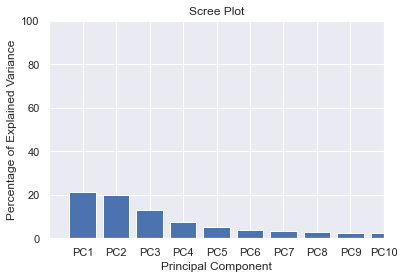

In [99]:
# Scree plot

# % of variation each PC accounts for:
per_var = np.round(pca.explained_variance_ratio_*100, decimals=1)
labels =['PC' + str(x) for x in range(1, len(per_var)+1)]

plt.bar(x=range(1, len(per_var)+1), height=per_var, tick_label=labels)
plt.ylabel('Percentage of Explained Variance')
plt.xlabel('Principal Component')
plt.title('Scree Plot')
plt.ylim([0,100])
plt.xlim([0,10])
plt.show()

In [100]:
# Creating a PC plot
# First we put the new coordinates created by pca.transform(scaled.data) into a nice matrix, where the rows have sample labels and the columns have PC labels
pca_df = pd.DataFrame(pca_data, columns=labels)
pca_df["country"] = df2050_by_country2.index # adding back geometric locations
pca_df.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14,PC15,PC16,PC17,PC18,PC19,PC20,PC21,PC22,PC23,PC24,PC25,PC26,PC27,PC28,PC29,PC30,PC31,PC32,PC33,PC34,PC35,PC36,PC37,PC38,PC39,PC40,PC41,PC42,PC43,PC44,PC45,PC46,PC47,PC48,PC49,PC50,PC51,PC52,PC53,PC54,PC55,PC56,PC57,PC58,PC59,PC60,PC61,PC62,PC63,PC64,PC65,PC66,PC67,PC68,PC69,PC70,PC71,PC72,PC73,PC74,PC75,PC76,PC77,PC78,PC79,PC80,country
0,-2.57,0.59,0.85,-0.47,1.45,0.58,1.31,2.19,0.38,-0.78,0.62,-0.42,-0.06,0.06,-0.80,0.31,-0.71,-0.31,0.52,-0.72,-0.33,-1.20,0.28,0.24,-0.14,-0.25,-0.03,0.14,1.29,0.22,-0.08,0.47,-0.11,0.15,0.05,0.11,-0.00,-0.14,-0.19,-0.29,-0.14,-0.39,0.21,-0.15,-0.22,0.00,0.06,0.23,-0.04,-0.04,-0.03,0.18,0.03,-0.03,0.05,0.11,0.00,0.03,-0.01,0.00,0.01,-0.01,-0.00,0.01,0.00,-0.00,0.00,-0.00,-0.00,0.00,-0.00,-0.00,0.00,-0.00,-0.00,-0.00,-0.00,-0.00,0.00,-0.00,Afghanistan
1,-4.64,-2.47,-1.64,0.29,-0.75,0.45,-0.46,-0.25,-0.69,0.10,-0.88,-0.66,-0.06,1.11,-0.35,-0.02,0.15,-0.30,-0.24,-0.22,-0.20,-0.35,-0.01,-0.45,-0.53,-0.15,0.42,0.16,0.10,0.24,-0.04,-0.13,-0.02,-0.26,0.22,-0.06,-0.10,-0.09,-0.09,0.06,0.00,-0.11,0.01,-0.09,0.11,-0.01,0.03,0.01,0.04,0.05,0.01,-0.05,-0.05,-0.02,-0.02,0.00,-0.02,-0.00,-0.00,-0.01,0.00,0.00,0.00,-0.00,-0.00,0.00,-0.00,0.00,0.00,-0.00,-0.00,0.00,0.00,-0.00,-0.00,0.00,-0.00,0.00,-0.00,-0.00,Algeria
2,-0.50,-1.71,-1.77,0.63,0.11,-0.12,0.53,0.68,0.95,-0.16,0.28,-0.10,0.05,-0.68,0.47,-0.47,-0.26,-0.00,0.54,0.31,-0.43,-0.11,-0.05,-0.47,-0.19,-0.20,0.15,0.47,-0.26,-0.12,0.04,-0.12,-0.20,0.34,0.21,-0.11,0.20,-0.03,0.18,0.03,0.05,-0.03,0.07,0.00,0.03,0.06,-0.09,0.05,0.04,0.08,-0.03,0.02,0.02,0.07,-0.02,-0.00,-0.01,-0.01,-0.01,-0.00,0.01,-0.00,-0.00,0.00,0.00,0.00,0.00,-0.00,0.00,-0.00,-0.00,-0.00,0.00,0.00,0.00,0.00,0.00,-0.00,0.00,-0.00,Angola
3,-2.58,-0.05,-0.78,0.32,-0.30,-0.60,0.40,-0.40,-0.37,0.55,-0.02,-0.20,-0.43,-1.05,0.85,-0.15,0.59,0.23,-0.11,0.23,-0.17,-0.16,0.18,0.14,-0.49,0.52,0.28,0.33,-0.08,0.18,0.16,-0.27,0.05,-0.09,0.00,-0.19,-0.21,-0.01,0.03,-0.14,0.02,0.03,-0.02,-0.03,0.10,0.11,-0.08,0.04,0.05,-0.02,0.00,0.06,0.01,0.03,-0.02,-0.03,-0.03,0.05,0.02,-0.01,-0.01,-0.00,-0.00,-0.01,0.00,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,0.00,0.00,0.00,-0.00,0.00,-0.00,-0.00,-0.00,0.00,Argentina
4,-3.55,-2.62,-1.62,0.22,-0.48,0.02,-0.30,-0.72,-0.43,-0.08,-0.68,-0.17,0.47,-0.18,-0.02,0.52,0.22,-0.19,-0.70,0.51,0.04,-0.10,0.35,0.09,-0.30,0.49,-0.07,0.22,-0.07,-0.09,-0.01,-0.09,0.15,0.39,-0.27,0.12,-0.10,0.06,0.08,-0.08,-0.15,-0.15,-0.13,0.06,0.14,0.20,-0.10,0.06,0.00,0.01,-0.13,0.04,-0.04,0.04,-0.04,-0.00,-0.03,0.00,0.01,0.01,-0.00,-0.01,0.00,-0.01,0.00,-0.01,0.00,-0.00,-0.00,-0.00,-0.00,0.00,-0.00,0.00,-0.00,-0.00,0.00,-0.00,-0.00,0.00,Australia


In [101]:
pca_df = pca_df.set_index("country")

### Scatter Plots

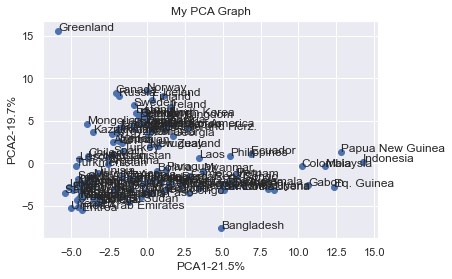

In [102]:
# Scatter plot PC1, PC2

plt.scatter(pca_df.PC1, pca_df.PC2)
plt.title('My PCA Graph')
plt.xlabel('PCA1-{0}%'.format(per_var[0]))
plt.ylabel('PCA2-{0}%'.format(per_var[1]))

for sample in pca_df.index:
    plt.annotate(sample, (pca_df.PC1.loc[sample], pca_df.PC2.loc[sample]))

plt.show()

# points that cluster together tend to be similar

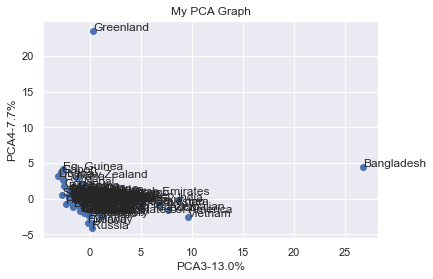

In [103]:
# Scatter plot PC3, PC4

plt.scatter(pca_df.PC3, pca_df.PC4)
plt.title('My PCA Graph')
plt.xlabel('PCA3-{0}%'.format(per_var[2]))
plt.ylabel('PCA4-{0}%'.format(per_var[3]))

for sample in pca_df.index:
    plt.annotate(sample, (pca_df.PC3.loc[sample], pca_df.PC4.loc[sample]))

plt.show()

# points that cluster together tend to be similar

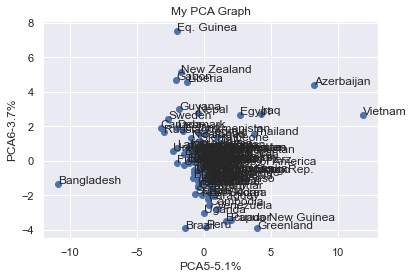

In [104]:
# Scatter plot PC5, PC6

plt.scatter(pca_df.PC5, pca_df.PC6)
plt.title('My PCA Graph')
plt.xlabel('PCA5-{0}%'.format(per_var[4]))
plt.ylabel('PCA6-{0}%'.format(per_var[5]))

for sample in pca_df.index:
    plt.annotate(sample, (pca_df.PC5.loc[sample], pca_df.PC6.loc[sample]))

plt.show()

# points that cluster together tend to be similar

In [106]:
column_names=list(df2050_by_country2.iloc[:, 2:].columns)

In [107]:
# Which variable had the biggest effect on separating the observations? => Loading scores on PC1

loading_scores = pd.Series(pca.components_[0])
sorted_loading_scores = loading_scores.abs().sort_values(ascending=False)
top_10_vars = sorted_loading_scores[0:10].index.values
print(loading_scores[top_10_vars])

68   0.23
62   0.23
13   0.23
6    0.23
67   0.23
34   0.22
65   0.22
4    0.22
66   0.22
77   0.22
dtype: float64


In [108]:
# Which variable had the biggest effect on separating the observations? => Loading scores on PCA4

loading_scores = pd.Series(pca.components_[5])
sorted_loading_scores = loading_scores.abs().sort_values(ascending=False)
top_10_vars = sorted_loading_scores[0:10].index.values
print(loading_scores[top_10_vars])

14   -0.33
25   -0.33
15   -0.25
24   -0.23
26   -0.23
35   -0.21
72   -0.19
39    0.17
60    0.17
42   -0.16
dtype: float64


### Correlation Plot

In [110]:
# Loadings Matrix

# component loadings or weights (correlation coefficient between original variables and the component) 
# component loadings represents the elements of the eigenvector
# the squared loadings within the PCs always sums to 1
loadings = pca_out.components_
num_pc = pca_out.n_features_
pc_list = ["PC"+str(i) for i in list(range(1, num_pc+1))]
loadings_df = pd.DataFrame.from_dict(dict(zip(pc_list, loadings)))
dfxx = df_geo.drop(['lon', 'lat', 'geometry'], axis=1)
loadings_df['variable'] = dfxx.columns.values
loadings_df = loadings_df.set_index('variable')
loadings_df

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14,PC15,PC16,PC17,PC18,PC19,PC20,PC21,PC22,PC23,PC24,PC25,PC26,PC27,PC28,PC29,PC30,PC31,PC32,PC33,PC34,PC35,PC36,PC37,PC38,PC39,PC40,PC41,PC42,PC43,PC44,PC45,PC46,PC47,PC48,PC49,PC50,PC51,PC52,PC53,PC54,PC55,PC56,PC57,PC58,PC59,PC60,PC61,PC62,PC63,PC64,PC65,PC66,PC67,PC68,PC69,PC70,PC71,PC72,PC73,PC74,PC75,PC76,PC77,PC78,PC79,PC80
variable,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2050_ACond_tavg,0.05,-0.03,-0.05,0.02,-0.11,0.07,0.17,-0.33,0.04,0.01,-0.13,0.26,-0.07,-0.28,-0.17,0.20,0.41,0.06,0.20,0.13,0.13,-0.09,-0.13,-0.02,-0.14,-0.27,0.01,-0.09,0.16,0.14,-0.01,-0.07,0.17,-0.07,0.11,0.02,0.06,-0.01,0.08,-0.20,0.07,-0.09,0.18,-0.14,0.02,0.07,-0.06,-0.09,0.02,0.02,-0.00,-0.02,0.01,-0.00,0.00,0.00,-0.01,0.01,-0.00,0.00,0.00,0.00,-0.00,0.00,0.00,-0.00,-0.00,-0.00,-0.00,0.00,0.00,0.00,-0.00,-0.00,-0.00,0.00,-0.00,0.00,0.00,-0.00
2050_Albedo_inst,0.02,-0.09,-0.00,-0.34,-0.09,0.12,-0.02,0.09,-0.04,0.05,0.02,-0.01,-0.05,-0.07,-0.01,-0.01,0.06,-0.03,0.05,0.04,-0.01,0.00,-0.01,-0.03,-0.06,0.06,0.07,0.11,0.03,0.06,0.04,0.00,-0.01,-0.04,0.03,-0.14,-0.10,0.10,0.02,-0.08,-0.09,-0.07,-0.04,0.30,-0.04,-0.14,0.20,-0.16,0.28,0.54,-0.12,0.18,0.21,-0.23,0.05,-0.01,0.14,-0.03,-0.02,0.00,-0.02,0.05,-0.04,0.01,-0.00,0.01,-0.01,0.00,0.00,0.00,-0.00,0.00,0.00,-0.00,-0.00,0.00,-0.00,-0.00,-0.00,-0.00
2050_AvgSurfT_inst,-0.00,-0.25,-0.04,-0.02,0.03,-0.03,-0.05,0.01,-0.03,-0.01,-0.02,0.01,-0.02,0.09,-0.05,-0.03,-0.01,-0.04,0.01,-0.04,-0.01,0.00,-0.07,-0.02,-0.01,-0.05,0.02,-0.02,0.05,-0.01,-0.05,0.04,0.00,-0.02,0.01,-0.01,0.01,0.01,0.04,0.02,-0.01,-0.10,0.01,0.09,-0.00,0.08,-0.03,0.07,-0.03,-0.03,0.05,-0.00,-0.04,0.16,-0.08,0.05,0.38,0.31,0.07,-0.03,-0.21,0.17,-0.14,-0.07,-0.09,-0.69,-0.06,-0.04,-0.01,-0.01,-0.00,-0.00,0.00,-0.00,-0.00,-0.00,0.00,-0.00,0.00,0.00
2050_CanopInt_inst,0.16,0.10,-0.01,-0.08,0.07,-0.12,-0.15,0.10,-0.10,-0.04,0.01,-0.10,0.12,0.15,0.03,-0.07,-0.05,-0.05,-0.05,0.23,0.09,0.04,0.00,0.01,-0.00,-0.13,-0.22,0.10,-0.44,-0.13,-0.18,0.11,0.24,-0.11,0.28,0.13,0.06,-0.16,-0.02,-0.22,0.08,-0.32,0.20,-0.08,-0.02,0.09,-0.02,-0.14,0.01,0.05,-0.04,0.02,0.05,-0.02,0.00,0.00,-0.01,0.01,-0.01,0.00,0.01,-0.00,-0.00,0.00,-0.00,-0.00,0.00,-0.00,-0.00,0.00,0.00,-0.00,-0.00,0.00,-0.00,0.00,0.00,0.00,0.00,-0.00
2050_ECanop_tavg,0.22,0.00,-0.06,0.00,-0.00,0.01,0.03,-0.07,-0.01,-0.04,0.04,-0.02,0.03,-0.02,-0.05,-0.01,0.11,0.03,0.07,0.12,0.03,0.02,-0.13,-0.06,0.07,-0.20,-0.08,-0.03,-0.06,-0.07,-0.12,-0.25,-0.08,-0.01,0.07,0.28,-0.26,-0.33,-0.24,0.15,-0.26,0.27,-0.02,0.30,-0.23,-0.03,0.10,0.14,0.10,-0.09,0.10,0.06,-0.08,-0.04,-0.02,-0.03,-0.01,0.04,-0.01,-0.03,0.07,0.07,-0.02,0.02,0.01,0.00,0.01,0.00,0.00,0.00,-0.00,-0.07,0.13,-0.00,-0.00,0.00,0.00,0.00,0.00,0.00
2050_ESoil_tavg,0.12,-0.07,0.07,-0.01,0.03,-0.07,0.07,-0.11,0.20,-0.08,0.38,0.05,-0.11,-0.21,0.01,-0.17,-0.03,-0.01,-0.02,-0.27,-0.27,0.01,0.22,0.16,-0.06,0.19,-0.02,0.04,0.12,-0.07,-0.13,0.09,0.00,0.06,0.27,0.11,0.04,0.04,-0.05,-0.31,0.05,0.09,0.16,0.02,-0.05,0.00,-0.07,-0.06,0.13,-0.05,0.10,0.01,-0.02,0.00,0.00,-0.02,0.01,0.06,-0.02,-0.05,0.13,0.11,-0.05,0.05,0.03,-0.00,0.01,0.00,0.00,0.00,-0.00,-0.11,0.21,-0.00,-0.00,0.00,0.00,0.00,0.00,0.00
2050_Evap_tavg,0.23,-0.03,-0.00,0.02,-0.00,0.05,0.02,-0.08,0.08,-0.05,0.12,-0.05,-0.02,-0.07,-0.01,-0.10,-0.04,0.02,-0.02,-0.07,0.01,0.02,0.07,-0.06,0.06,-0.06,-0.04,0.12,0.00,0.07,0.01,-0.05,0.04,-0.09,-0.06,-0.03,0.04,-0.02,-0.00,0.02,0.00,-0.05,-0.04,-0.02,0.03,0.03,-0.04,0.08,0.14,-0.01,0.11,0.05,-0.01,-0.02,0.06,-0.07,0.03,-0.13,0.08,0.15,-0.42,-0.32,0.17,-0.16,-0.07,-0.01,-0.01,-0.12,0.57,0.23,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,0.00,-0.00,-0.00,-0.00
2050_LWdown_f_tavg,0.07,-0.23,-0.03,-0.02,0.02,-0.06,-0.07,-0.06,-0.04,-0.02,0.00,-0.05,-0.02,0.13,-0.05,-0.03,0.05,0.03,-0.07,-0.05,-0.00,-0.10,-0.12,0.10,-0.00,-0.03,0.04,0.01,0.12,-0.01,-0.07,0.04,-0.09,-0.01,-0.02,0.04,0.02,-0.04,-0.13,-0.00,-0.03,-0.11,0.01,-0.06,0.06,0.03,-0.00,0.03,-0.00,0.08,0.03,-0.

In [111]:
# Sorting loadings by PC1
loadings_sorted_df = loadings_df.sort_values("PC1")
loadings_sorted_df.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14,PC15,PC16,PC17,PC18,PC19,PC20,PC21,PC22,PC23,PC24,PC25,PC26,PC27,PC28,PC29,PC30,PC31,PC32,PC33,PC34,PC35,PC36,PC37,PC38,PC39,PC40,PC41,PC42,PC43,PC44,PC45,PC46,PC47,PC48,PC49,PC50,PC51,PC52,PC53,PC54,PC55,PC56,PC57,PC58,PC59,PC60,PC61,PC62,PC63,PC64,PC65,PC66,PC67,PC68,PC69,PC70,PC71,PC72,PC73,PC74,PC75,PC76,PC77,PC78,PC79,PC80
variable,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2050_Qh_tavg,-0.15,-0.12,-0.04,0.00,0.05,-0.14,-0.00,0.14,0.05,0.12,-0.08,0.14,0.11,-0.19,0.03,0.16,0.09,0.05,-0.05,0.20,-0.04,-0.01,0.05,0.14,-0.00,0.18,-0.08,-0.07,0.01,-0.16,-0.12,-0.09,-0.23,0.06,-0.04,0.01,-0.09,0.03,-0.20,0.02,-0.11,-0.22,-0.06,-0.07,0.12,0.17,-0.09,-0.01,-0.02,-0.02,-0.20,0.08,-0.00,-0.08,-0.01,-0.02,-0.04,0.11,-0.03,-0.07,0.19,0.17,-0.08,0.07,0.04,-0.00,0.05,-0.09,0.45,0.18,-0.00,-0.00,0.00,-0.00,-0.00,-0.00,0.00,-0.00,-0.00,-0.00
2050_Wind_f_inst,-0.09,-0.06,-0.02,0.05,-0.07,-0.03,-0.01,-0.40,-0.14,-0.09,-0.18,0.17,-0.03,0.12,0.13,0.05,0.13,0.02,-0.19,0.03,0.02,0.02,0.41,-0.11,-0.27,0.15,0.19,0.32,-0.20,-0.09,-0.10,-0.03,-0.12,-0.20,0.08,0.08,0.10,0.03,0.04,0.18,0.07,0.07,-0.01,0.17,-0.05,0.07,-0.00,0.07,-0.00,0.01,-0.05,0.03,-0.00,0.04,-0.02,0.02,-0.01,-0.02,-0.00,-0.00,0.00,-0.00,0.00,0.00,0.00,0.00,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,0.00,0.00,0.00,-0.00,0.00,-0.00,-0.00,-0.00
2050_Qs_acc,-0.08,0.03,-0.01,-0.16,0.18,-0.33,0.05,0.07,0.01,-0.11,-0.02,-0.11,0.22,0.08,0.10,0.00,0.15,-0.14,0.05,0.20,-0.02,0.15,0.00,0.07,-0.30,-0.20,0.13,-0.06,-0.04,0.03,0.11,-0.01,-0.23,0.22,0.06,-0.19,0.06,0.11,0.10,-0.06,0.01,0.07,0.06,-0.06,-0.01,-0.03,-0.03,0.20,0.32,-0.02,0.33,-0.00,-0.12,-0.00,0.07,-0.07,-0.00,-0.04,-0.01,-0.01,-0.01,0.01,0.01,-0.00,-0.01,0.00,0.00,0.00,-0.00,-0.00,-0.00,0.00,0.00,-0.00,0.00,0.00,-0.00,-0.00,0.00,0.00
2050_Qsb_acc,-0.06,-0.01,0.02,-0.08,0.04,-0.25,0.15,-0.15,0.12,-0.34,-0.12,-0.14,-0.04,0.06,0.03,0.27,-0.13,-0.09,0.24,0.01,-0.21,-0.02,-0.39,-0.16,0.09,0.41,-0.05,0.17,-0.04,0.03,-0.13,-0.19,0.10,-0.20,0.01,-0.05,-0.01,-0.00,0.05,-0.05,-0.02,0.04,-0.02,-0.08,0.02,-0.01,-0.03,0.02,0.03,0.02,0.02,-0.01,-0.02,-0.01,0.01,-0.01,-0.00,-0.00,-0.00,-0.01,-0.00,0.00,0.01,-0.00,-0.00,0.00,-0.00,0.00,0.00,0.00,0.00,0.00,0.00,-0.00,0.00,0.00,-0.00,-0.00,0.00,0.00
2050_qrswb,-0.06,-0.07,-0.01,-0.00,0.08,-0.05,0.12,-0.00,-0.02,-0.01,0.02,0.19,-0.34,0.08,0.67,-0.26,-0.02,0.06,0.16,0.11,0.32,0.13,-0.08,0.11,-0.04,0.06,-0.18,0.04,0.15,0.07,0.05,0.01,0.02,-0.05,0.00,-0.04,-0.02,-0.10,-0.05,-0.04,-0.05,0.01,0.00,-0.02,-0.01,0.04,-0.00,0.00,-0.02,-0.00,0.02,-0.01,0.06,0.01,0.01,0.00,0.00,0.00,0.01,-0.06,-0.00,-0.01,0.01,-0.01,0.01,-0.00,0.00,-0.00,-0.00,-0.00,0.00,0.00,-0.00,0.02,0.00,0.01,0.00,-0.00,0.11,0.00


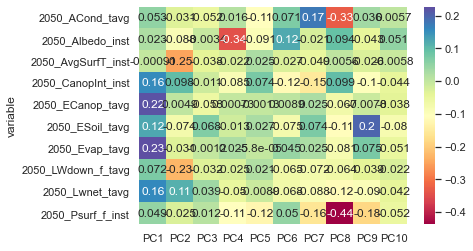

In [112]:
# positive and negative values in component loadings reflects the positive and negative 
# correlation of the variables with the PCs. Except A and B, all other variables have 
# positive projection on first PC.

# (First 10 variables on the first 10 PC's only, more cannot be visualized at once)
# get correlation matrix plot for loadings
ax = sns.heatmap(loadings_df.iloc[0:10, 0:10], annot=True, cmap='Spectral')
plt.show()

In [113]:
# on loadings_sorted_df 
%matplotlib qt 

ax = sns.heatmap(loadings_sorted_df.iloc[0:, 0:10], annot=True, cmap='Spectral')
plt.show()

In [114]:
# all at once...
%matplotlib qt 

ax = sns.heatmap(loadings_sorted_df, annot=True, cmap='Spectral')
plt.show()


IndexError: index 11 is out of bounds for axis 0 with size 11

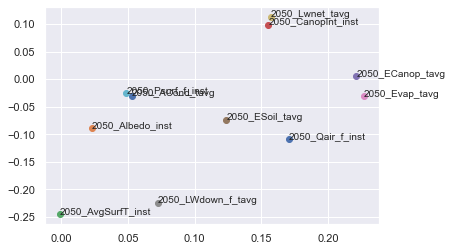

In [115]:
# get PCA loadings plots (2D and 3D)
%matplotlib inline

## First 10 variables from the unordered df on the first 10PC

# 2D
cluster.pcaplot(x=loadings[0][0:11], y=loadings[1][0:11], labels=dfxx.columns.values, 
    var1=round(pca_out.explained_variance_ratio_[0]*100, 2),
    var2=round(pca_out.explained_variance_ratio_[1]*100, 2))


IndexError: index 11 is out of bounds for axis 0 with size 11

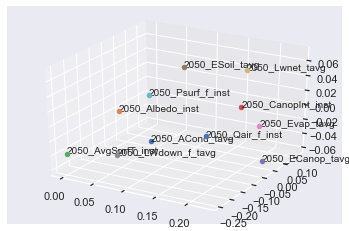

In [116]:
# 3D

## First 10 variables from the unordered df on the first 10PC

cluster.pcaplot(x=loadings[0][0:11], y=loadings[1][0:11], z=loadings[2][0:11],  labels=dfxx.columns.values, 
    var1=round(pca_out.explained_variance_ratio_[0]*100, 2), var2=round(pca_out.explained_variance_ratio_[1]*100, 2), 
    var3=round(pca_out.explained_variance_ratio_[2]*100, 2))

## Biplots

In [118]:
# In biplot, the PC loadings and scores are plotted in a single figure
# biplots are useful to visualize the relationships between variables and observations
%matplotlib inline

## First 10 variables from the unordered df on the first 10PC

# get PC scores
pca_scores = PCA().fit_transform(scaled_data)

# get 2D biplot of PC1 and PC2
cluster.biplot(cscore=pca_scores, loadings=loadings, labels=dfxx.columns.values, 
    var1=round(pca_out.explained_variance_ratio_[0]*100, 2),
    var2=round(pca_out.explained_variance_ratio_[1]*100, 2))
    

In [119]:
# get 3D biplot
cluster.biplot(cscore=pca_scores, loadings=loadings, labels=dfxx.columns.values, 
    var1=round(pca_out.explained_variance_ratio_[0]*100, 2), 
    var2=round(pca_out.explained_variance_ratio_[1]*100, 2), 
    var3=round(pca_out.explained_variance_ratio_[2]*100, 2))

# World Poverty Index

Mozambique


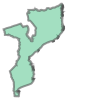

In [54]:
from shapely import wkt

wpif = pd.read_csv("data/wpif.csv")
mozambique = wkt.loads(wpif.iloc[0]['the_geom'])
print(wpif.iloc[0]['NAME'])
mozambique

In [51]:
master_df[master_df.intersects(mozambique)].shape
# 33 1 degree cells match mozambique

(33, 2203)

In [49]:
crs = {'init': 'epsg:4326'}
geo = [wkt.loads(mpolygons) for mpolygons in wpif['the_geom']]
wpif_gf = geopandas.GeoDataFrame(wpif, crs=crs, geometry=geo)
gdf_intersect = geopandas.sjoin(master_df, wpif_gf, how="inner", op='intersects')
gdf_intersect

,lon,lat,2000_ACond_tavg,2000_Albedo_inst,2000_AvgSurfT_inst,2000_CanopInt_inst,2000_ECanop_tavg,2000_ESoil_tavg,2000_Evap_tavg,2000_LWdown_f_tavg,...,2015_ncrunnat,2016_ncrunnat,index_right,FID,the_geom,OBJECTID,ISO,NAME,UNESCOMEMB,WPI
0,-179.5,67.5,0.016219,39.998020,261.982452,0.028931,2.330008,15.343687,0.000009,229.330368,...,0.000026,0.000019,209,wpif.211,MULTIPOLYGON (((146.01804100000004 43.37793940...,204,RUS,Russian Federation,Russian Federation,63.4
1,-178.5,67.5,0.016937,40.676281,262.283844,0.036311,2.233058,15.203341,0.000009,229.323456,...,0.000022,0.000018,209,wpif.211,MULTIPOLYGON (((146.01804100000004 43.37793940...,204,RUS,Russian Federation,Russian Federation,63.4
2,-177.5,66.5,0.018806,39.602760,263.464081,0.022502,1.618066,16.863810,0.000009,238.398178,...,0.000018,0.000017,209,wpif.211,MULTIPOLYGON (((146.01804100000004 43.37793940...,204,RUS,Russian Federation,Russian Federation,63.4
3,-177.5,67.5,0.017559,40.260284,263.129944,0.031821,2.382056,14.701731,0.000009,235.138351,...,0.000013,0.000010,209,wpif.211,MULTIPOLYGON (((146.01804100000004 43.37793940...,204,RUS,Russian Federation,Russian Federation,63.4
4,-176.5,66.5,0.019091,39.242260,263.903259,0.020268,1.530059,16.375177,0.000009,238.532364,...,0.000016,0.000017,209,wpif.211,MULTIPOLYGON (((146.01804100000004 43.37793940...,204,RUS,Russian Federation,Russian Federation,63.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10811,169.5,-44.5,0.022976,19.539923,275.850525,0.094677,7.432333,31.183109,0.000018,292.664368,...,0.000029,0.000037,189,wpif.189,MULTIPOLYGON (((169.1988525390001 -52.46692275...,179,NZL,New Zealand,New Zealand,60.8
10819,170.5,-44.5,0.024121,17.699976,278.923218,0.073006,9.571005,40.399059,0.000024,296.372131,...,0.000005,0.000007,189,wpif.189,MULTIPOLYGON (((169.1988525390001 -52.46692275...,179,NZL,New Zealand,New Zealand,60.8
10835,172.5,-42.5,0.024165,14.778844,278.754700,0.151941,12.595078,33.358429,0.000023,311.685425,...,0.000029,0.000032,189,wpif.189,MULTIPOLYGON (((169.1988525390001 -52.46692275...,179,NZL,New Zealand,New Zealand,60.8
10857,175.5,-38.5,0.020660,17.081402,285.399811,0.174712,12.089117,27.376980,0.000018,322.678406,...,0.000024,0.000023,189,wpif.189,MULTIPOLYGON (((169.1988525390001 -52.46692275...,179,NZL,New Zealand,New Zealand,60.8


In [110]:
from sklearn.model_selection import train_test_split
countries = list(set(gdf_intersect['ISO']))
train_countries, test_countries = train_test_split(countries, test_size=0.2, random_state=42)
train_data = gdf_intersect[gdf_intersect['ISO'].isin(train_countries)]
test_data = gdf_intersect[gdf_intersect['ISO'].isin(test_countries)]

train_y = train_data['WPI']
train_x = train_data.iloc[:,2:-8].drop(['geometry'], axis=1)
test_y = test_data['WPI']
test_x = test_data.iloc[:,2:-8].drop(['geometry'], axis=1)

In [118]:
from sklearn import svm
model = svm.LinearSVR()
model.fit(train_x, train_y)

LinearSVR()

In [119]:
predicted_y = model.predict(test_x)
predicted_y

array([21.99816526, 29.46913261,  2.5719089 , ...,  0.15141675,
       -2.31070196, 16.93312699])

In [120]:
test_y

0        63.4
1        63.4
2        63.4
3        63.4
4        63.4
         ... 
10263    66.2
8425     58.5
8484     58.5
8485     58.5
8702     58.5
Name: WPI, Length: 3655, dtype: float64